<a href="https://colab.research.google.com/github/ftamaki/postech/blob/main/TechChallenge_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ===============================================================================
# IMPORTAÇÃO DOS PACOTES UTILIZADOS
# ===============================================================================
import pandas as pd  # Para manipulação e análise de dados em estruturas como DataFrames.
import numpy as np   # Para operações matemáticas eficientes com arrays e matrizes.

# ===============================================================================
# 2. Bibliotecas para Visualização de Dados
# ===============================================================================

import matplotlib.pyplot as plt  # Para criar gráficos e visualizações estáticas.
import seaborn as sns            # Baseada no Matplotlib, para criar gráficos estatísticos mais atraentes.
import missingno as msno         # Para visualizar dados faltantes (missing data) de forma elegante.

# ===============================================================================
# 3. Pré-processamento, Seleção de Features e Balanceamento
# ===============================================================================

from sklearn.model_selection import train_test_split   # Para dividir os dados em conjuntos de treino e teste.
from sklearn.preprocessing import StandardScaler       # Para padronizar a escala das features (média 0, desvio padrão 1).
from sklearn.feature_selection import SelectKBest, chi2, f_classif # Para selecionar as melhores features com base em testes estatísticos (Qui-quadrado, ANOVA F-value).
from imblearn.over_sampling import SMOTE               # Para balancear o dataset criando amostras sintéticas da classe minoritária.
from sklearn.model_selection import GridSearchCV

# ===============================================================================
# 4. Modelos de Machine Learning
# ===============================================================================

from sklearn.linear_model import LogisticRegression    # Modelo linear para classificação.
from sklearn.neighbors import KNeighborsClassifier     # Modelo baseado na proximidade dos "vizinhos" mais próximos.
from sklearn.tree import DecisionTreeClassifier        # Modelo baseado em uma estrutura de árvore de decisões.
from sklearn.ensemble import RandomForestClassifier    # Modelo de Ensemble que combina múltiplas árvores de decisão.
from sklearn.svm import SVC                            # Support Vector Classifier, para criar fronteiras de decisão complexas.
from xgboost import XGBClassifier                      # Modelo de Gradient Boosting, conhecido por sua alta performance e velocidade.

# ===============================================================================
# 5. Métricas para Avaliação de Modelos
# ===============================================================================
from sklearn.metrics import (
    accuracy_score,                # Mede a proporção de previsões corretas (Acurácia).
    classification_report,         # Gera um relatório completo com precisão, recall, f1-score por classe.
    confusion_matrix,              # Cria uma matriz para visualizar os erros e acertos do modelo.
    f1_score,                      # Média harmônica entre precisão e recall, ótima para dados desbalanceados.
    precision_score,               # Mede a exatidão das previsões positivas (Precisão).
    recall_score,                  # Mede a capacidade do modelo de encontrar todos os positivos (Revocação/Sensibilidade).
    roc_auc_score,                 # Mede a área sob a curva ROC, avaliando a capacidade de distinção entre classes.
    mean_absolute_error,           # Erro médio absoluto (geralmente para regressão).
    mean_squared_error,            # Erro quadrático médio (geralmente para regressão).
    precision_recall_curve         # Retorna as curvas de precisão e revocação para diferentes thresholds.
)

# ===============================================================================
# 6. Configurações e Utilitários do Ambiente 🔧
# ===============================================================================

# Para ignorar e não exibir mensagens de aviso (warnings).
import warnings
warnings.filterwarnings("ignore")

# Comando do Jupyter para exibir gráficos diretamente na célula de output.
%matplotlib inline

# importação para leitura dos arquivos sistema operacional
import os
# importação do kagglehub para baixar os arquivos diretamente via python
import kagglehub

In [ ]:
# ===============================================================================
# Tratamento dos dados - Baixando, listando e normalizando o target 'Diabetes_binary'
# ===============================================================================

# Baixando o dataset
path = kagglehub.dataset_download("alexteboul/diabetes-health-indicators-dataset")
print("Path para os arquivos:", path)

# Listar arquivos CSV
files = [f for f in os.listdir(path) if f.endswith('.csv')]
print("Arquivos CSV encontrados:", files)

# Carregar os DataFrames em um dicionário
dfs = {}
for f in files:
    full_path = os.path.join(path, f)
    df_temp = pd.read_csv(full_path)

    # Transformar a coluna alvo corretamente
    if 'Diabetes_012' in df_temp.columns:
        # Mapear valores 0 → 0 (sem diabetes ou só gravidez), 1 e 2 → 1 (pré-diabetes e diabetes)
        df_temp['Diabetes_binary'] = df_temp['Diabetes_012'].map(lambda x: 0 if x == 0 else 1)

        # Dropar a coluna original
        df_temp.drop(columns=['Diabetes_012'], inplace=True)

    elif 'Diabetes_binary' in df_temp.columns:
        # Garantir que está tudo certo
        df_temp['Diabetes_binary'] = df_temp['Diabetes_binary'].map(lambda x: 0 if x == 0 else 1)

    dfs[f] = df_temp

# Verificar diferenças nas colunas
print("\nComparando colunas dos arquivos:")
all_columns = {name: set(df.columns) for name, df in dfs.items()}
for name, columns in all_columns.items():
    print(f"- {name}: {len(columns)} colunas\n")

# Comparar quais colunas são diferentes
base = list(all_columns.values())[0]
for name, columns in all_columns.items():
    diff = base.symmetric_difference(columns)
    if diff:
        print(f"⚠️ Diferenças entre base e {name}: {diff}")
    else:
        print(f"✅ {name} tem as mesmas colunas da base.")

# Identificar colunas comuns
common_columns = set.intersection(*all_columns.values())

# Juntar os DataFrames com base nas colunas comuns
#df = pd.concat([df_temp[list(common_columns)] for df_temp in dfs.values()], ignore_index=True)
df = pd.concat([df[list(common_columns)] for df in dfs.values()], ignore_index=True)

# Exibir resultado final
print("\n✅ Shape do DataFrame combinado:", df.shape)
print(df["Diabetes_binary"].value_counts())
pd.set_option('display.max_columns', None)
df.head(5)


Path para os arquivos: /kaggle/input/diabetes-health-indicators-dataset
Arquivos CSV encontrados: ['diabetes_binary_5050split_health_indicators_BRFSS2015.csv', 'diabetes_binary_health_indicators_BRFSS2015.csv', 'diabetes_012_health_indicators_BRFSS2015.csv']

Comparando colunas dos arquivos:
- diabetes_binary_5050split_health_indicators_BRFSS2015.csv: 22 colunas

- diabetes_binary_health_indicators_BRFSS2015.csv: 22 colunas

- diabetes_012_health_indicators_BRFSS2015.csv: 22 colunas

✅ diabetes_binary_5050split_health_indicators_BRFSS2015.csv tem as mesmas colunas da base.
✅ diabetes_binary_health_indicators_BRFSS2015.csv tem as mesmas colunas da base.
✅ diabetes_012_health_indicators_BRFSS2015.csv tem as mesmas colunas da base.

✅ Shape do DataFrame combinado: (578052, 22)
Diabetes_binary
0    467383
1    110669
Name: count, dtype: int64


,GenHlth,Stroke,AnyHealthcare,HighBP,Education,Sex,HighChol,CholCheck,Age,Income,HeartDiseaseorAttack,DiffWalk,PhysHlth,Veggies,NoDocbcCost,BMI,PhysActivity,HvyAlcoholConsump,MentHlth,Smoker,Fruits,Diabetes_binary
0,3.0,0.0,1.0,1.0,6.0,1.0,0.0,1.0,4.0,8.0,0.0,0.0,30.0,1.0,0.0,26.0,1.0,0.0,5.0,0.0,0.0,0
1,3.0,1.0,1.0,1.0,6.0,1.0,1.0,1.0,12.0,8.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,1.0,1.0,0
2,1.0,0.0,1.0,0.0,6.0,1.0,0.0,1.0,13.0,8.0,0.0,0.0,10.0,1.0,0.0,26.0,1.0,0.0,0.0,0.0,1.0,0
3,3.0,0.0,1.0,1.0,6.0,1.0,1.0,1.0,11.0,8.0,0.0,0.0,3.0,1.0,0.0,28.0,1.0,0.0,0.0,1.0,1.0,0
4,2.0,0.0,1.0,0.0,5.0,0.0,0.0,1.0,8.0,8.0,0.0,0.0,0.0,1.0,0.0,29.0,1.0,0.0,0.0,1.0,1.0,0


In [ ]:
rows , col =  df.shape
print(f"Número de Linhas : {rows} \nNúmero de Colunas : {col}")

Número de Linhas : 578052 
Número de Colunas : 22


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578052 entries, 0 to 578051
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   GenHlth               578052 non-null  float64
 1   Stroke                578052 non-null  float64
 2   AnyHealthcare         578052 non-null  float64
 3   HighBP                578052 non-null  float64
 4   Education             578052 non-null  float64
 5   Sex                   578052 non-null  float64
 6   HighChol              578052 non-null  float64
 7   CholCheck             578052 non-null  float64
 8   Age                   578052 non-null  float64
 9   Income                578052 non-null  float64
 10  HeartDiseaseorAttack  578052 non-null  float64
 11  DiffWalk              578052 non-null  float64
 12  PhysHlth              578052 non-null  float64
 13  Veggies               578052 non-null  float64
 14  NoDocbcCost           578052 non-null  float64
 15  

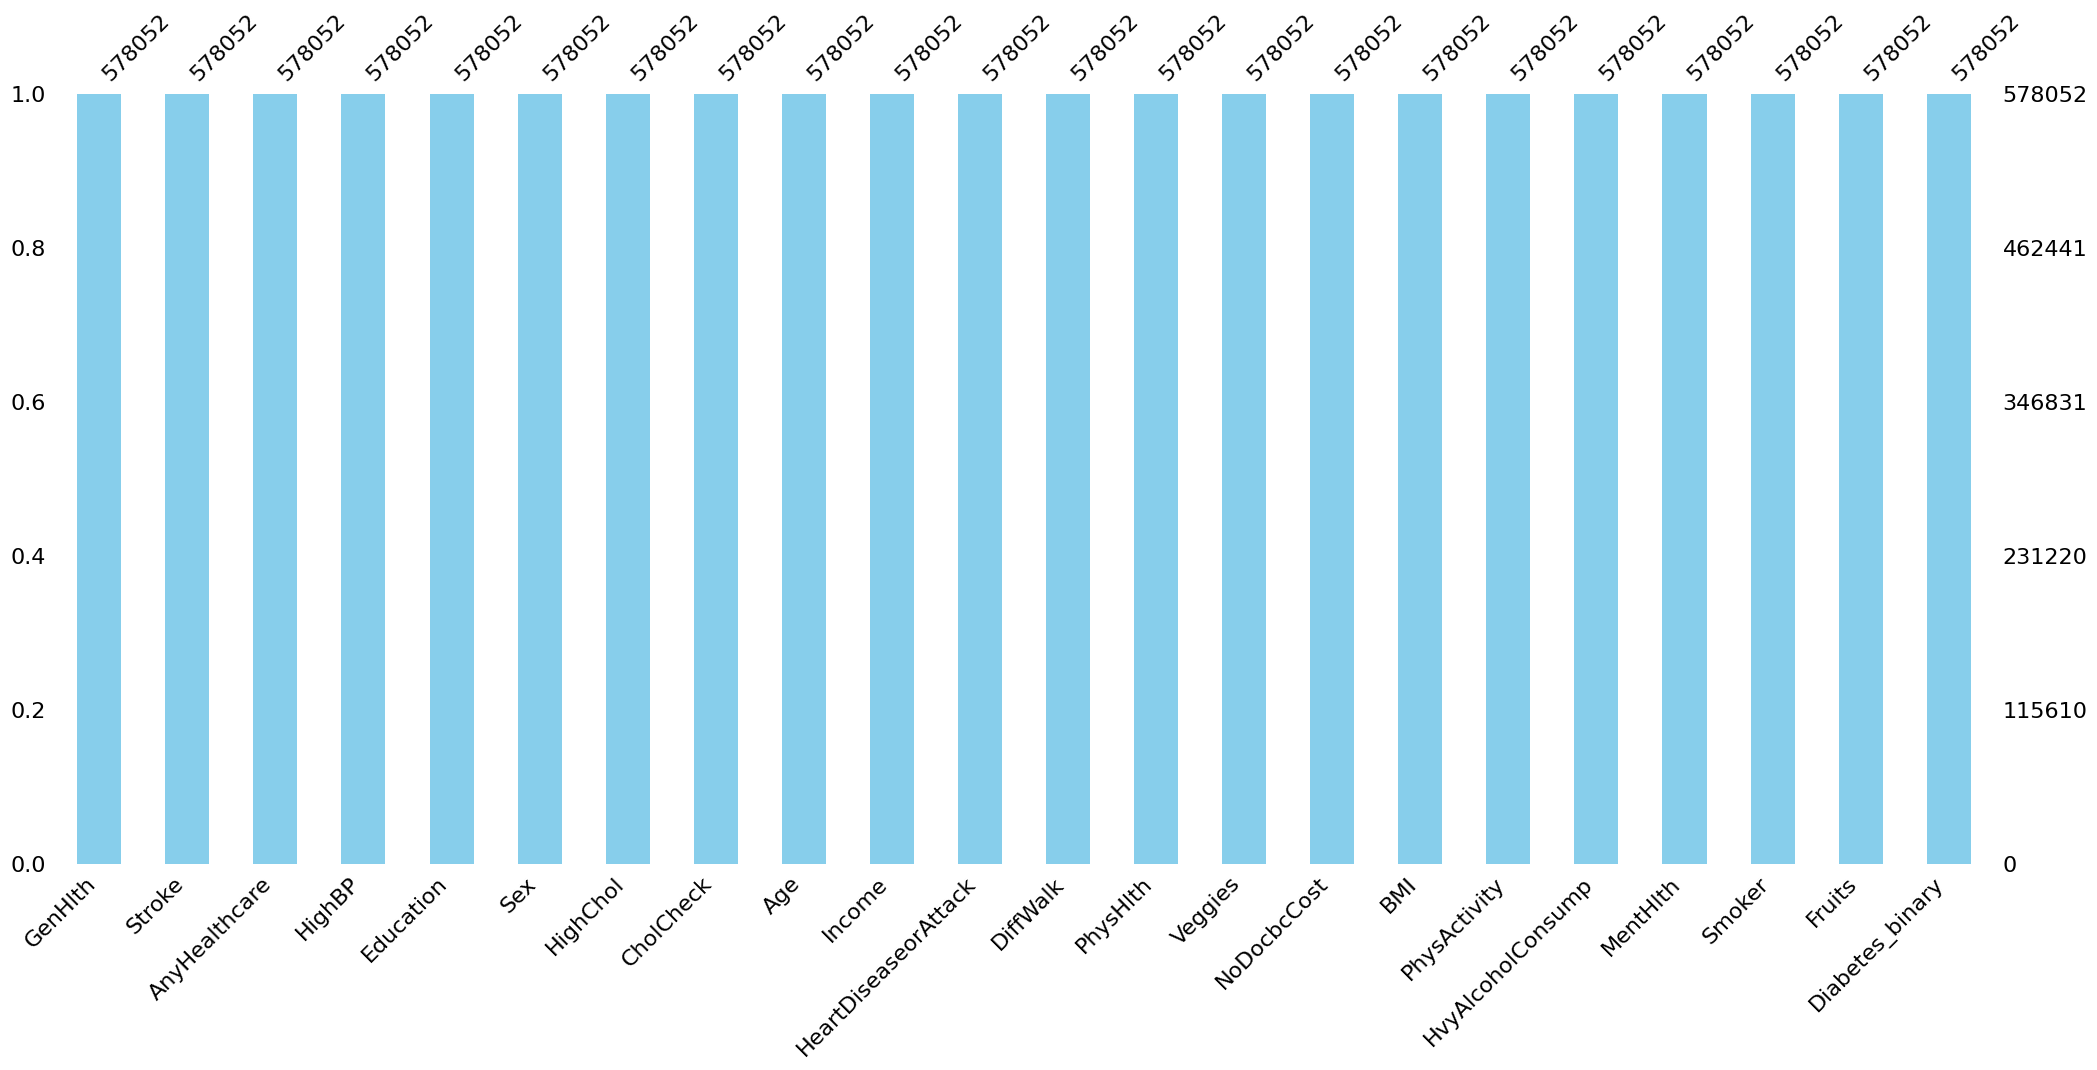

In [ ]:
# Cria um gráfico de barras que mostra a quantidade de dados não-nulos em cada coluna.
# É usado para identificar rapidamente se e onde existem dados faltantes no DataFrame.
msno.bar(df, color='skyblue')
plt.show()


In [ ]:
#Descrevendo todas as colunas
pd.set_option('display.max_rows', None)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
GenHlth,578052.0,2.551222,1.079378,1.0,2.00,2.0,3.0,5.0
Stroke,578052.0,0.043212,0.203335,0.0,0.00,0.0,0.0,1.0
AnyHealthcare,578052.0,0.951530,0.214757,0.0,1.00,1.0,1.0,1.0
HighBP,578052.0,0.445444,0.497015,0.0,0.00,0.0,1.0,1.0
Education,578052.0,5.034599,0.992077,1.0,4.00,5.0,6.0,6.0
Sex,578052.0,0.442379,0.496669,0.0,0.00,0.0,1.0,1.0
HighChol,578052.0,0.436544,0.495957,0.0,0.00,0.0,1.0,1.0
CholCheck,578052.0,0.964209,0.185769,0.0,1.00,1.0,1.0,1.0
Age,578052.0,8.099617,3.035618,1.0,6.00,8.0,10.0,13.0
Income,578052.0,6.010392,2.087400,1.0,5.00,7.0,8.0,8.0


In [ ]:
#Verificando quais colunas tem valores binários, listando unique count de cada uma
unique_values = {}
for col in df.columns:
    unique_values[col] = df[col].value_counts().shape[0]

pd.DataFrame(unique_values, index=['Valores Unicos nas colunas']).transpose()

,Valores Unicos nas colunas
GenHlth,5
Stroke,2
AnyHealthcare,2
HighBP,2
Education,6
Sex,2
HighChol,2
CholCheck,2
Age,13
Income,8


In [ ]:
# Verificando dados duplicados
duplicates = df[df.duplicated()]
print("Linhas Duplicadas : ",len(duplicates))

Linhas Duplicadas :  344018


In [ ]:
# ===============================================================================
# Tratamento dos dados - removendo duplicadas
# ===============================================================================

df_clean = df.drop_duplicates().copy()
# Dimensões do DataFrame original
rows_orig, col_orig = df.shape
print(f"Número de Linhas (original): {rows_orig} \nNúmero de Colunas: {col_orig}")

# Dimensões após remoção de duplicatas
rows_clean, col_clean = df_clean.shape
print(f"Número de Linhas (sem duplicatas): {rows_clean} \nNúmero de Colunas: {col_clean}")

# Quantidade de linhas removidas
print(f"\nTotal de duplicatas removidas: {rows_orig - rows_clean}")

Número de Linhas (original): 578052 
Número de Colunas: 22
Número de Linhas (sem duplicatas): 234034 
Número de Colunas: 22

Total de duplicatas removidas: 344018


---
# **Visualização dos Dados**



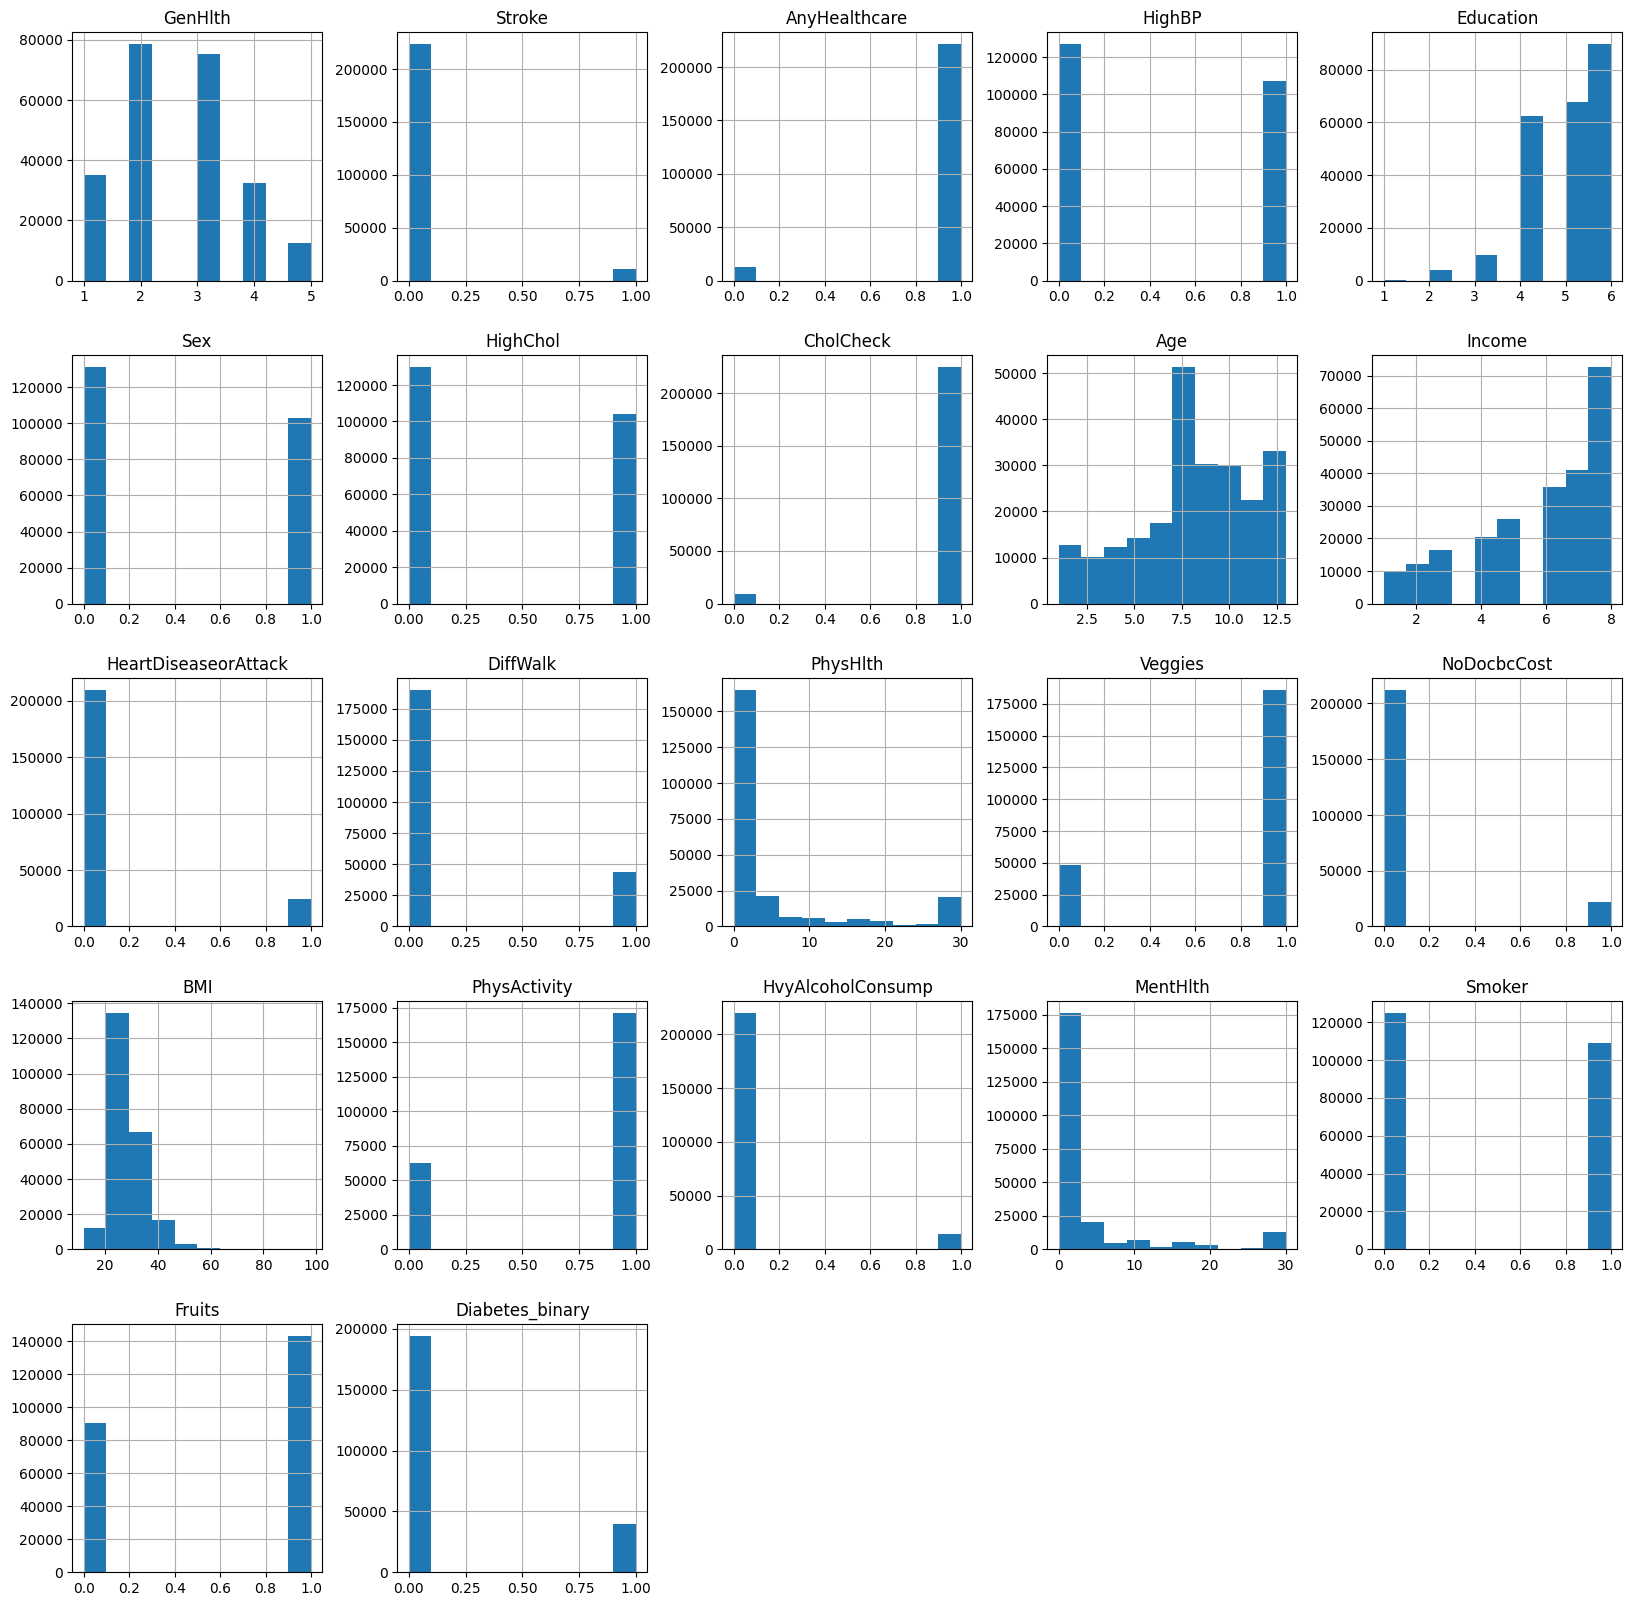

In [ ]:
df_clean.hist(figsize = (20,20))
plt.show()

📊 Correlação com Diabetes_binary:
GenHlth                 0.275863
HighBP                  0.254186
BMI                     0.205788
DiffWalk                0.202984
HighChol                0.198763
Age                     0.180750
HeartDiseaseorAttack    0.163467
PhysHlth                0.154819
Stroke                  0.095784
CholCheck               0.074581
MentHlth                0.056839
Smoker                  0.045288
Sex                     0.030248
NoDocbcCost             0.024483
AnyHealthcare           0.023497
Fruits                 -0.024513
Veggies                -0.042293
HvyAlcoholConsump      -0.064930
PhysActivity           -0.100085
Education              -0.105410
Income                 -0.143738
Name: Diabetes_binary, dtype: float64


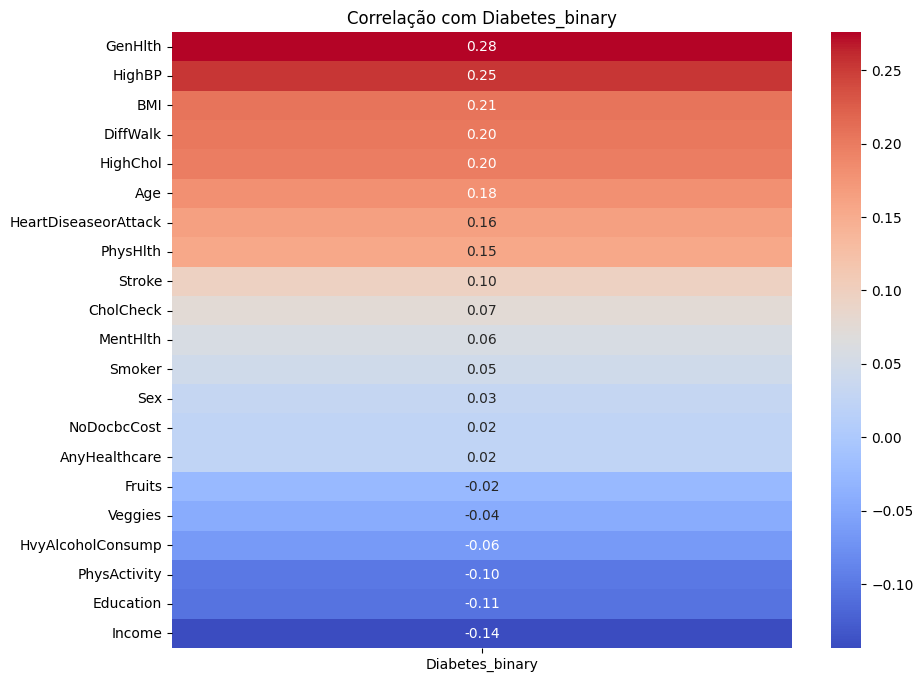

In [ ]:
# Calcular a correlação
correlation = df_clean.corr(numeric_only=True)

# Correlacionar com o target
cor_target = correlation['Diabetes_binary'].drop('Diabetes_binary').sort_values(ascending=False)

# Exibir as variáveis mais correlacionadas
print("📊 Correlação com Diabetes_binary:")
print(cor_target)

# Visualizar com heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cor_target.to_frame(), annot=True, cmap='coolwarm', fmt='.2f')

plt.title("Correlação com Diabetes_binary")
plt.show()


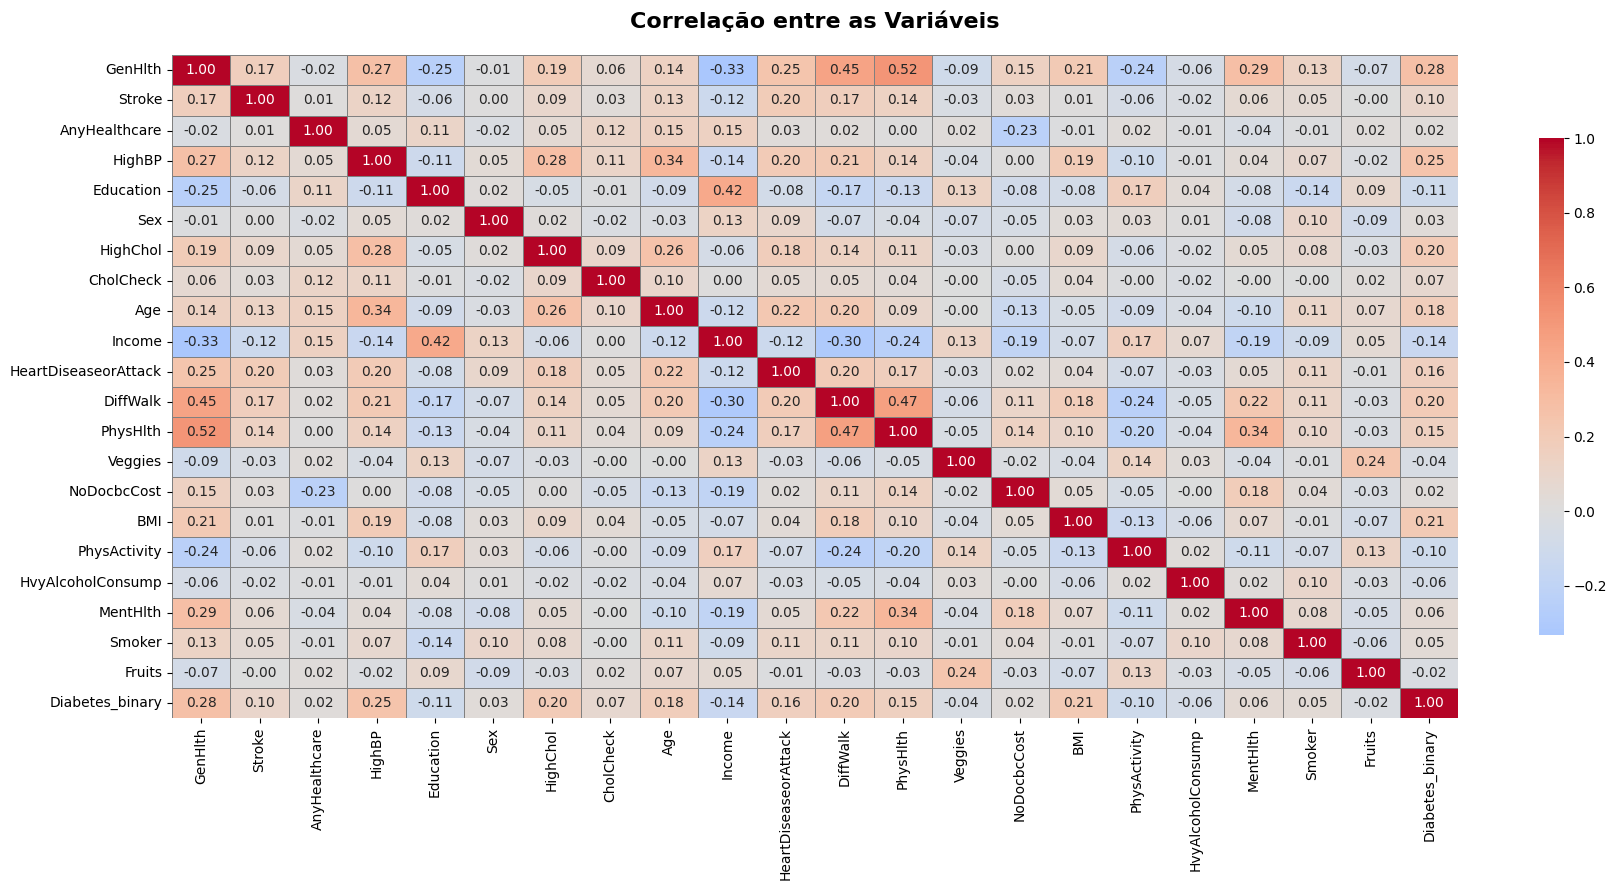

In [ ]:
corr = df_clean.corr(numeric_only=True)  # garante apenas colunas numéricas

fig, ax = plt.subplots(figsize=(18, 9))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={"shrink": 0.75},
    ax=ax
)

ax.set_title("Correlação entre as Variáveis", fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


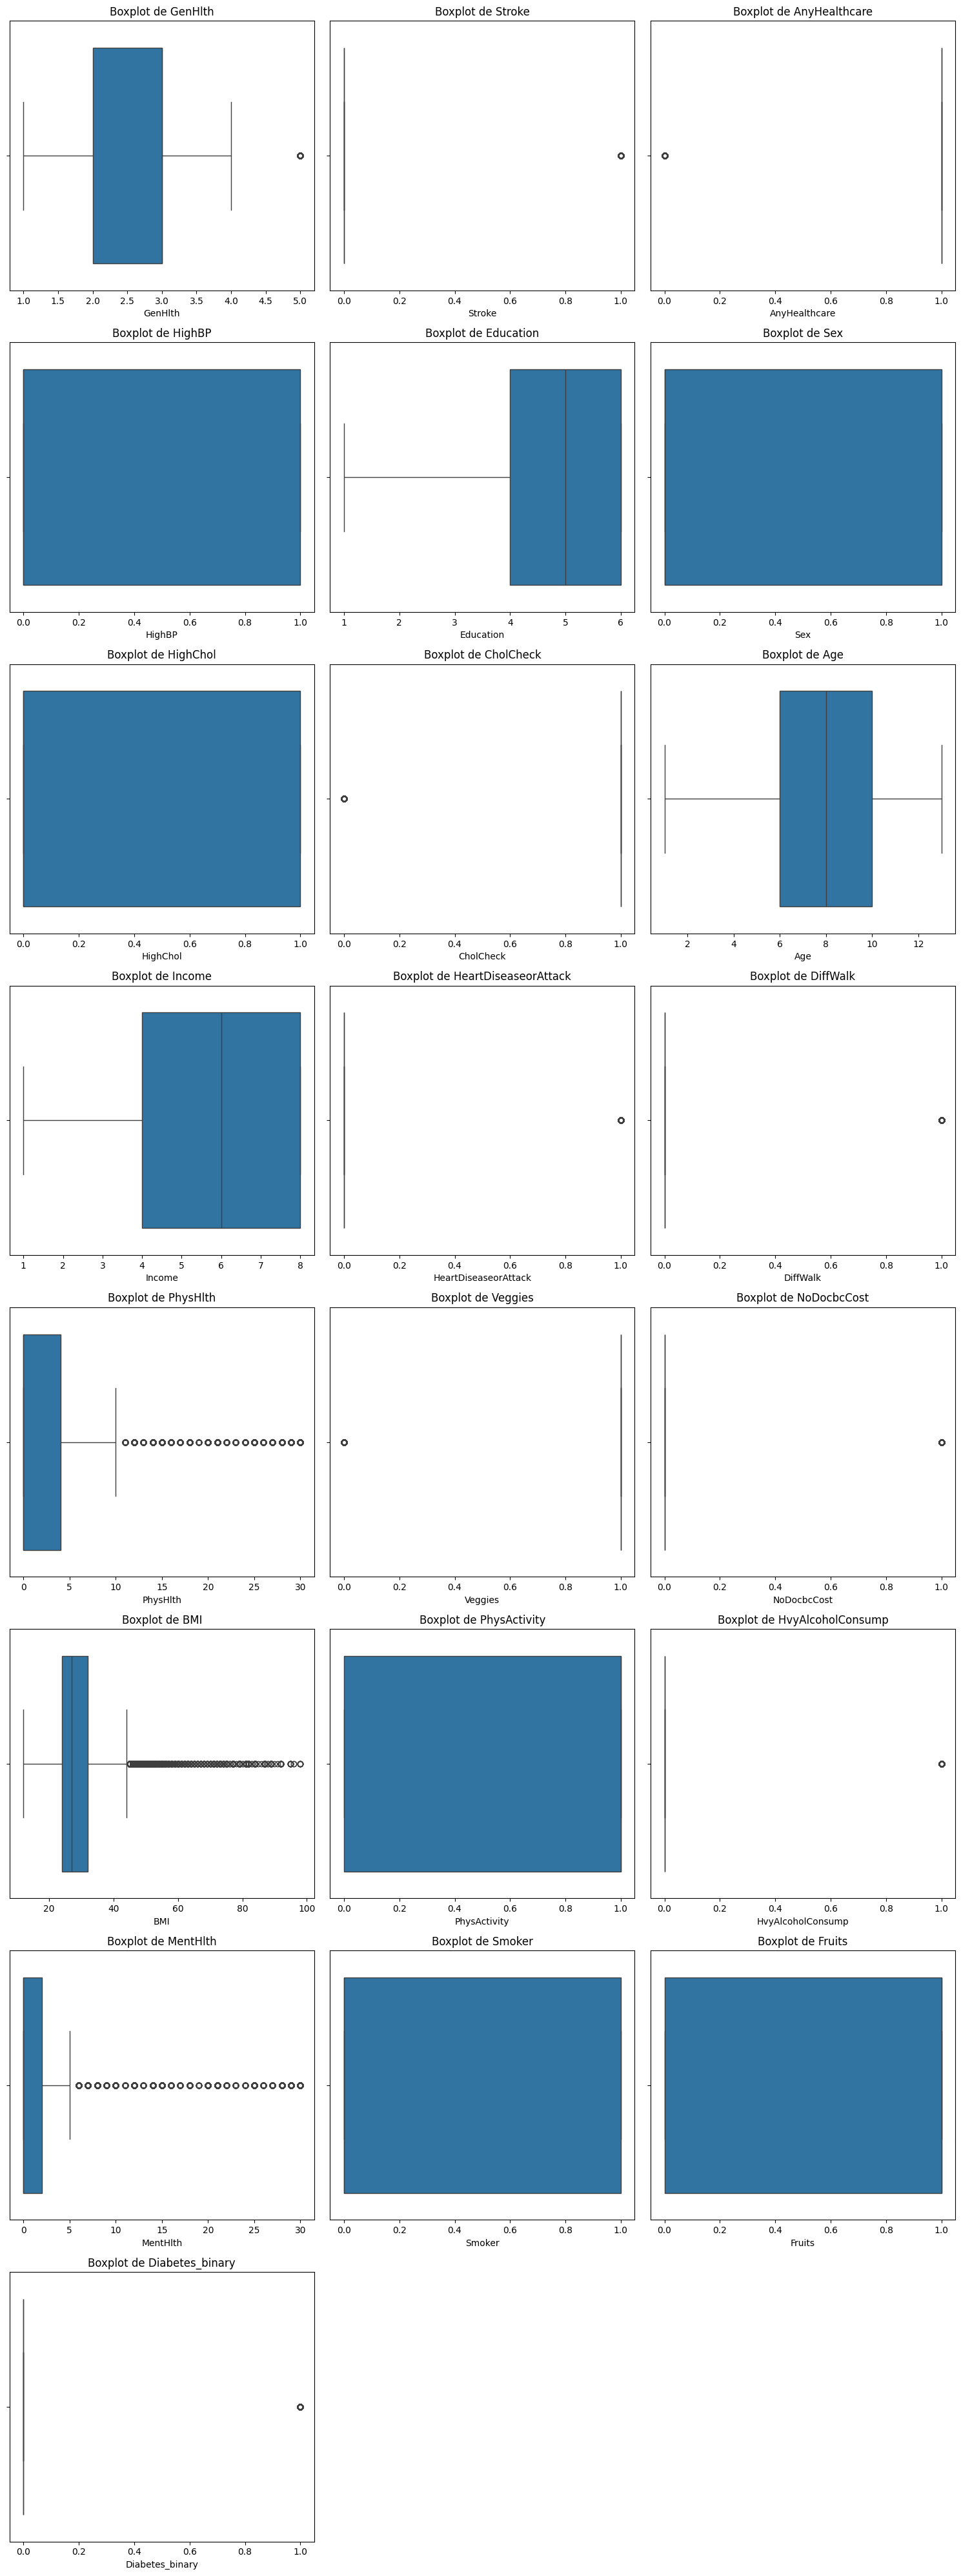

In [ ]:
# Selecionar apenas colunas numéricas
numeric_columns = df_clean.select_dtypes(include='number').columns

# Criar subplots
n_cols = 3
n_rows = -(-len(numeric_columns) // n_cols)  # arredondamento para cima
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
axes = axes.flatten()  # transforma em vetor para acesso simples

# Criar boxplots
for i, column in enumerate(numeric_columns):
    sns.boxplot(data=df_clean, x=column, ax=axes[i])
    axes[i].set_title(f'Boxplot de {column}')

# Remover eixos não usados (caso sobre espaço no grid)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Gerando boxplots comparativos por status de Diabetes...


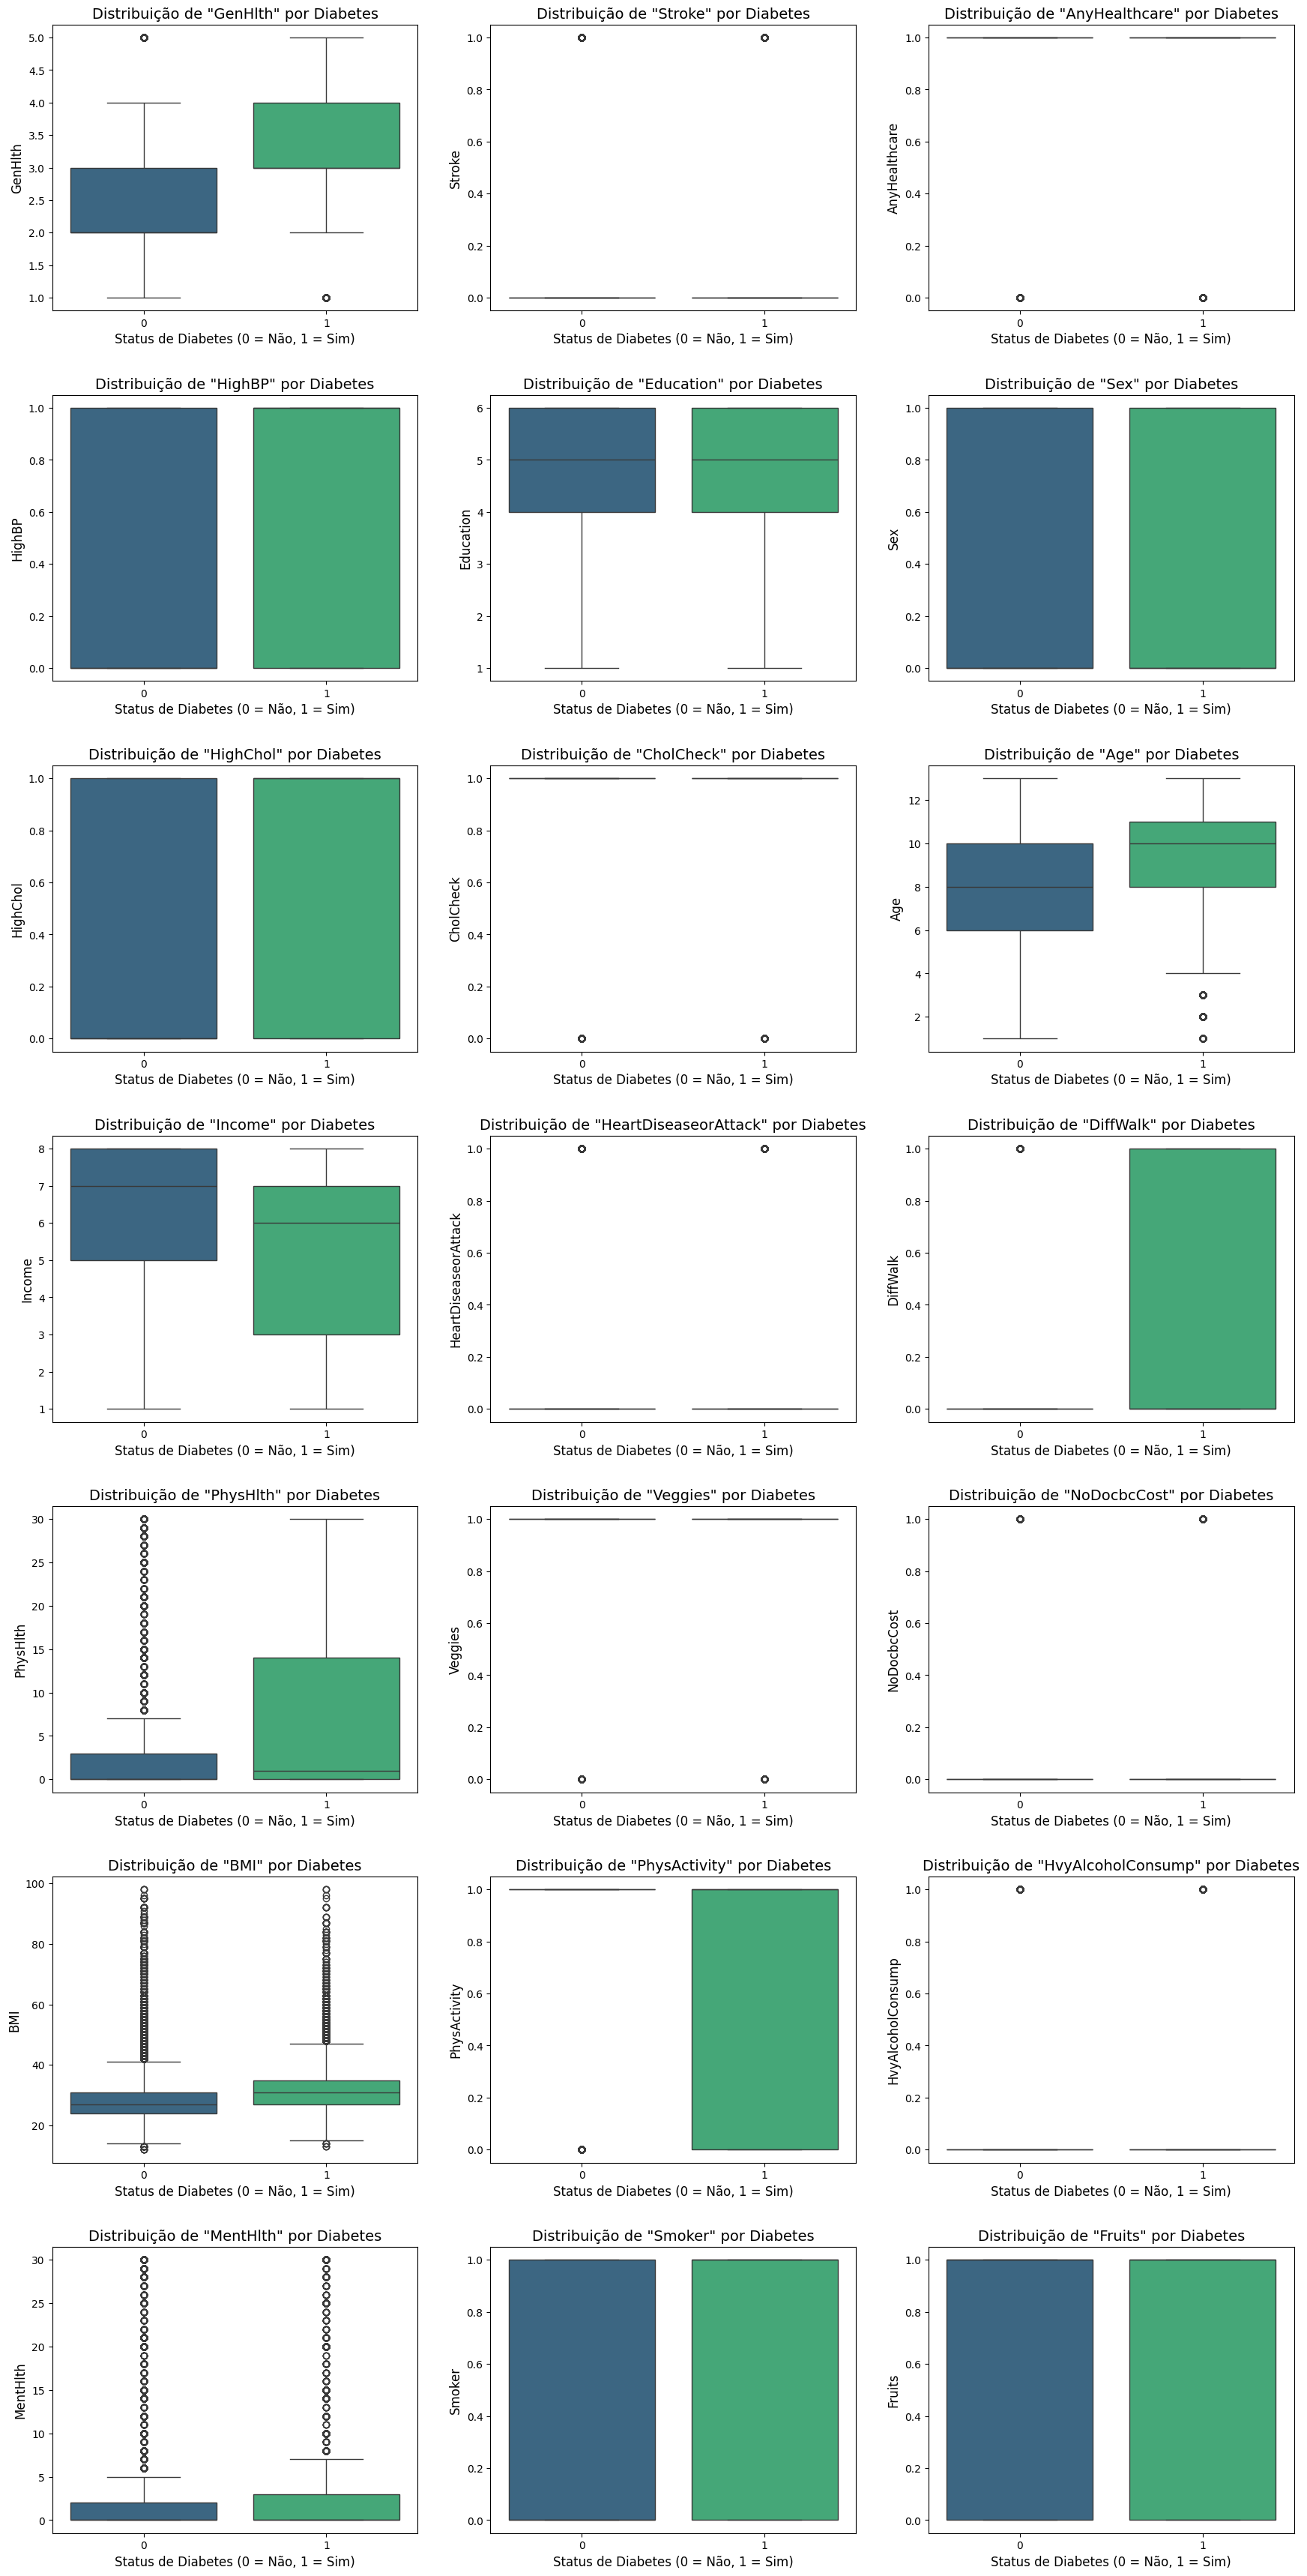

In [ ]:
# Definir a variável alvo para comparação
target = 'Diabetes_binary'

# Selecionar apenas as colunas numéricas (excluindo a própria variável alvo, se já for numérica)
numeric_columns = df_clean.select_dtypes(include='number').columns.drop(target)

# Criar subplots de forma mais inteligente
n_cols = 3
# Calcula o número de linhas necessárias para acomodar todas as colunas
n_rows = -(-len(numeric_columns) // n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

print("Gerando boxplots comparativos por status de Diabetes...")

# Criar boxplots comparativos
for i, column in enumerate(numeric_columns):
    # y=column e x=target
    # cria um boxplot da 'column' para cada categoria única em 'target'
    sns.boxplot(data=df_clean, y=column, x=target, ax=axes[i], palette="viridis")
    axes[i].set_title(f'Distribuição de "{column}" por Diabetes', fontsize=14)
    axes[i].set_ylabel(column, fontsize=12)
    axes[i].set_xlabel("Status de Diabetes (0 = Não, 1 = Sim)", fontsize=12)

# Ocultar eixos extras que não foram usados
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajusta o layout para evitar sobreposição de títulos e eixos
plt.tight_layout(pad=3.0)
plt.show()

Gerando countplots para 18 variáveis categóricas...


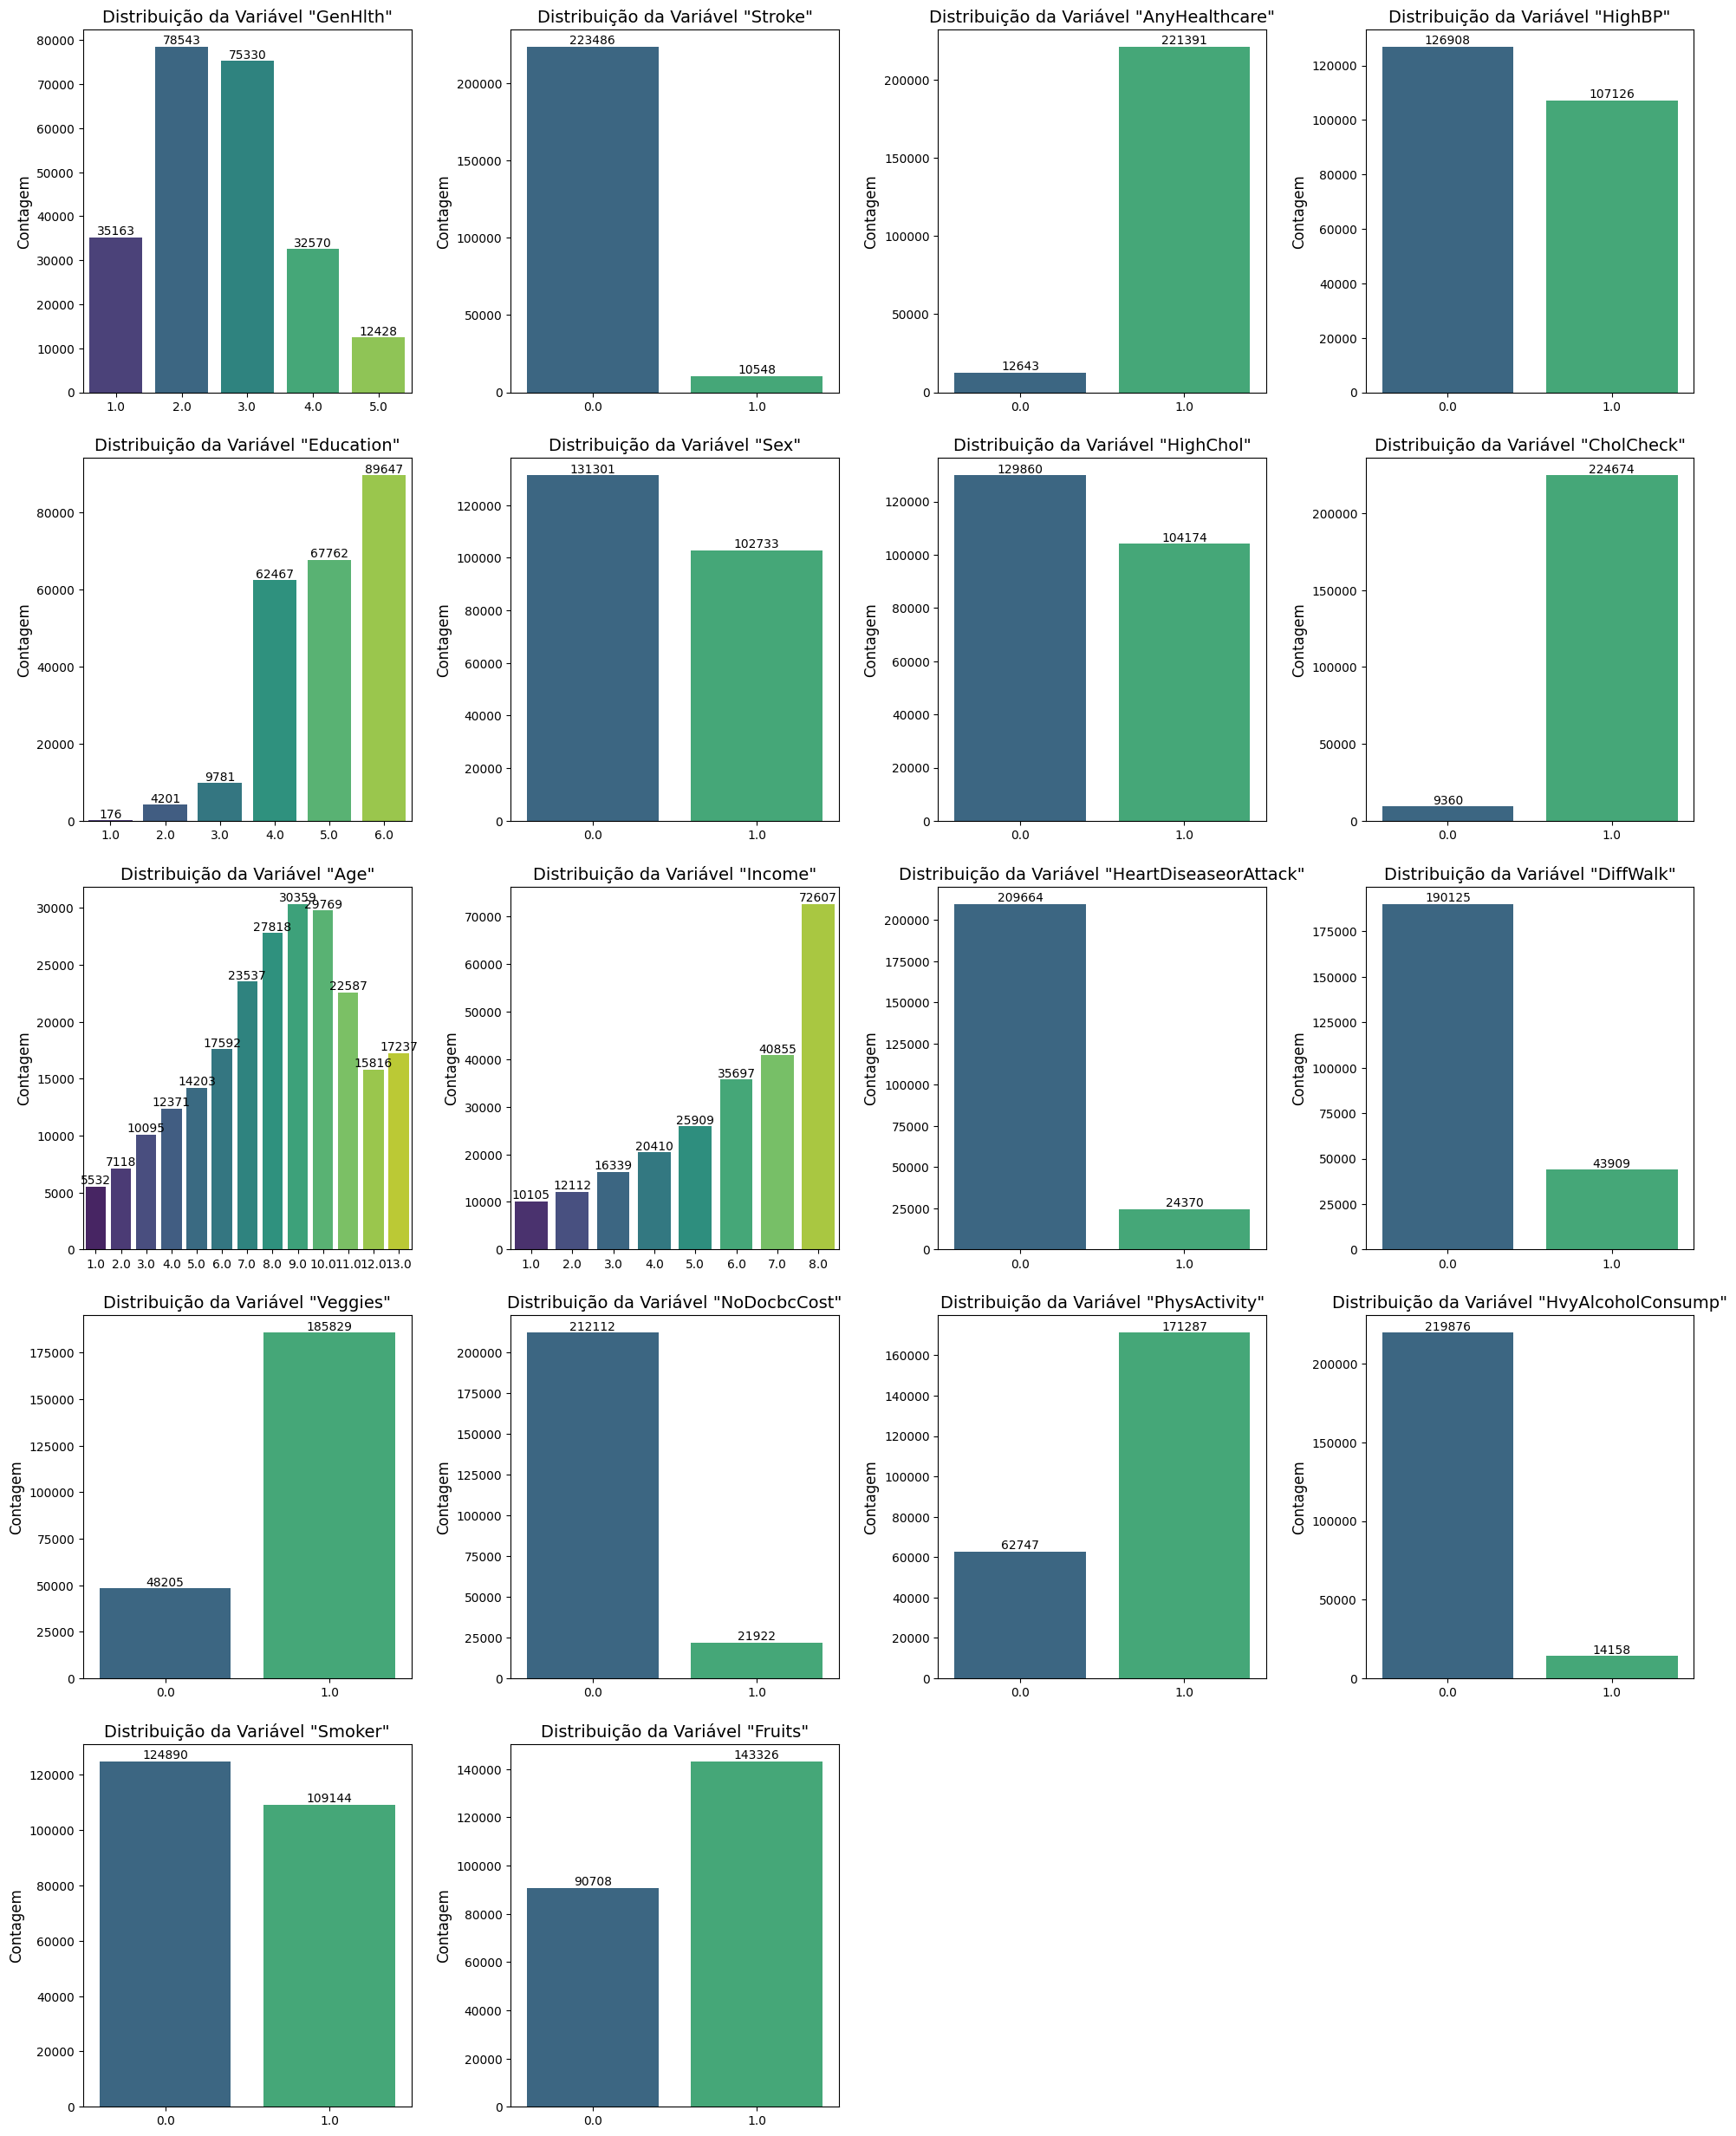

In [ ]:
# Seleciona colunas categóricas/binárias com até 13 valores únicos (incluindo 'Age'),
# excluindo a variável alvo 'Diabetes_binary' para manter apenas as features.

cols_for_countplot = [
    col for col in df_clean.columns
    if df_clean[col].nunique() <= 13 and col != 'Diabetes_binary'
]

# --- Criação dos Gráficos ---

# Definir o layout da grade de visualizações
n_cols = 4  # Quantos gráficos por linha
n_rows = -(-len(cols_for_countplot) // n_cols)  # Calcula o número de linhas necessárias

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()  # Transforma a matriz de eixos em um vetor para facilitar o loop

print(f"Gerando countplots para {len(cols_for_countplot)} variáveis categóricas...")

# Loop para criar um countplot para cada coluna selecionada
for i, column in enumerate(cols_for_countplot):
    sns.countplot(data=df_clean, x=column, ax=axes[i], palette="viridis")
    axes[i].set_title(f'Distribuição da Variável "{column}"', fontsize=14)
    axes[i].set_xlabel(None)  # Remove o nome do eixo x para um visual mais limpo
    axes[i].set_ylabel('Contagem', fontsize=12)
    # Adiciona os rótulos de contagem em cima de cada barra
    for container in axes[i].containers:
        axes[i].bar_label(container, fontsize=10)


# Ocultar os eixos que não foram usados
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajusta o layout para que os gráficos não se sobreponham
plt.tight_layout(pad=2.0)
plt.show()

In [ ]:
df_clean['Diabetes_binary'].unique()

array([0, 1])

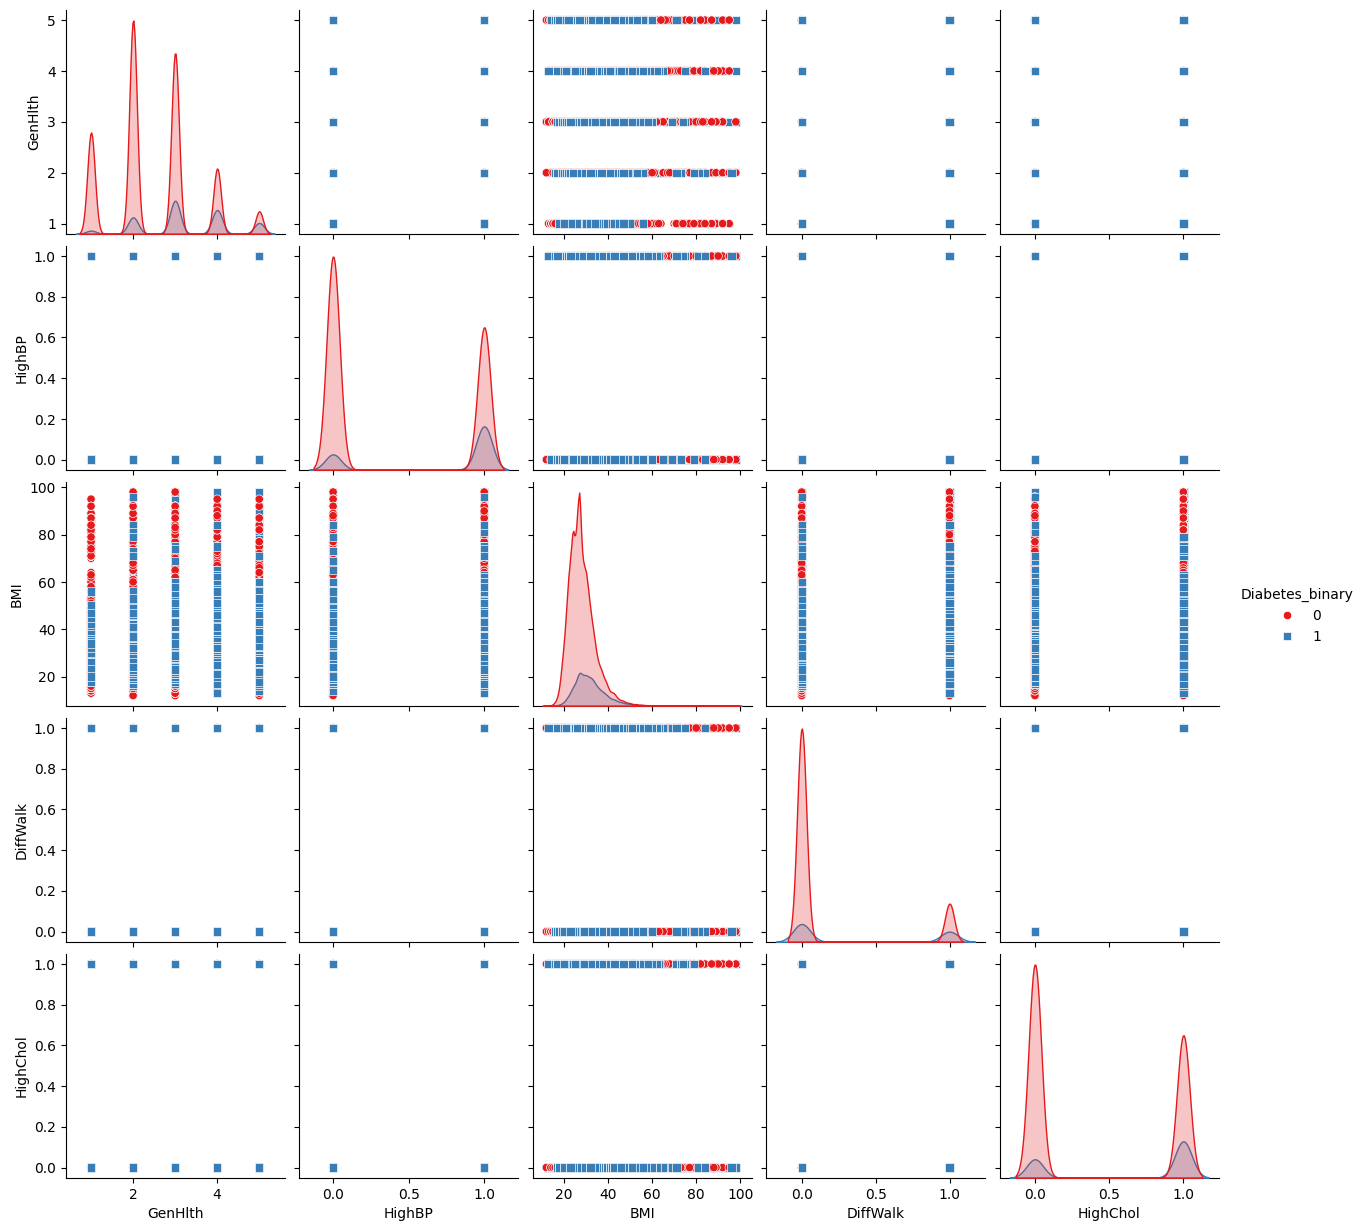

In [ ]:
# Cria uma matriz de gráficos (pairplot) para visualizar a relação entre as principais variáveis do estudo.
# A função colore os dados usando o status de 'Diabetes_binary' (parâmetro 'hue') para comparar os dois grupos.
# A diagonal mostra a distribuição de cada variável e os outros gráficos mostram a dispersão entre os pares.

cols = ['GenHlth', 'HighBP', 'BMI', 'DiffWalk', 'HighChol', 'Diabetes_binary']
sns.pairplot(data=df_clean[cols], hue='Diabetes_binary', diag_kind='kde', markers=["o", "s"], palette="Set1")
plt.show()

In [ ]:
# Mapeando os valores 0 e 1 para descrições
diabetes_map = {0: "Não Diabético", 1: "Diabético"}

# Contando os valores e renomeando os índices com base no mapa
tabela_diabetes = df_clean["Diabetes_binary"].value_counts().rename(index=diabetes_map)

# Exibindo a tabela
print(tabela_diabetes)


Diabetes_binary
Não Diabético    194377
Diabético         39657
Name: count, dtype: int64


📊 Correlação com Diabetes_binary:
GenHlth                 0.275863
HighBP                  0.254186
BMI                     0.205788
DiffWalk                0.202984
HighChol                0.198763
Age                     0.180750
HeartDiseaseorAttack    0.163467
PhysHlth                0.154819
Stroke                  0.095784
CholCheck               0.074581
MentHlth                0.056839
Smoker                  0.045288
Sex                     0.030248
NoDocbcCost             0.024483
AnyHealthcare           0.023497
Fruits                 -0.024513
Veggies                -0.042293
HvyAlcoholConsump      -0.064930
PhysActivity           -0.100085
Education              -0.105410
Income                 -0.143738
Name: Diabetes_binary, dtype: float64


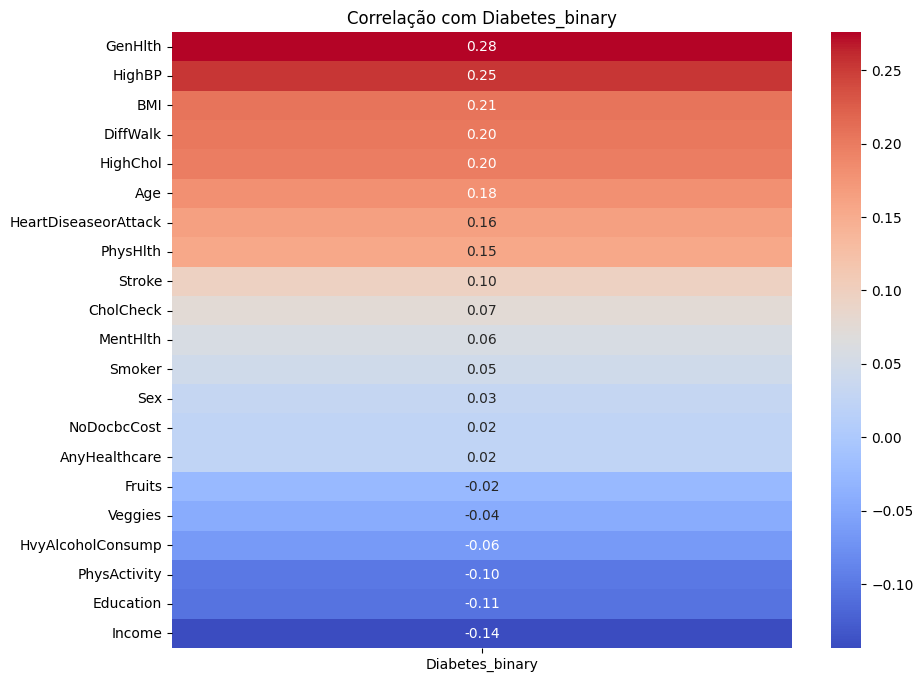

In [ ]:
# Calcular a correlação
correlation = df_clean.corr(numeric_only=True)

# Correlacionar com o target
cor_target = correlation['Diabetes_binary'].drop('Diabetes_binary').sort_values(ascending=False)

# Exibir as variáveis mais correlacionadas
print("📊 Correlação com Diabetes_binary:")
print(cor_target)

# Visualizar com heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cor_target.to_frame(), annot=True, cmap='coolwarm', fmt='.2f') #arredondando
plt.title("Correlação com Diabetes_binary")
plt.show()


In [ ]:
# 1. Separar X e y ...
target = 'Diabetes_binary'
X_full = df_clean.drop(columns=[target])
y = df_clean[target]

# 2. Dividir em treino e teste
X_train_full, X_test_full, y_train, y_test = train_test_split(X_full, y, test_size=0.3, random_state=42, stratify=y)

# 3. Treinar modelo com TODAS as variáveis
model_full = RandomForestClassifier(random_state=42)
model_full.fit(X_train_full, y_train)
y_pred_full = model_full.predict(X_test_full)

print("\n📊 Modelo completo (todas as features):")
print(classification_report(y_test, y_pred_full))

# 4. Selecionar apenas as TOP 5 variáveis
top5_features = ['GenHlth', 'HighBP', 'BMI', 'DiffWalk', 'HighChol']
X_top5 = df_clean[top5_features]
X_train_top5, X_test_top5, _, _ = train_test_split(X_top5, y, test_size=0.3, random_state=42, stratify=y)

# 5. Treinar modelo com apenas top 5
model_top5 = RandomForestClassifier(random_state=42)
model_top5.fit(X_train_top5, y_train)
y_pred_top5 = model_top5.predict(X_test_top5)

print("\n📊 Modelo com TOP 5 features:")
print(classification_report(y_test, y_pred_top5))



📊 Modelo completo (todas as features):
              precision    recall  f1-score   support

           0       0.85      0.95      0.89     58314
           1       0.39      0.17      0.24     11897

    accuracy                           0.81     70211
   macro avg       0.62      0.56      0.57     70211
weighted avg       0.77      0.81      0.78     70211


📊 Modelo com TOP 5 features:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     58314
           1       0.55      0.13      0.21     11897

    accuracy                           0.83     70211
   macro avg       0.70      0.55      0.56     70211
weighted avg       0.80      0.83      0.79     70211



In [ ]:
target = 'Diabetes_binary'
X = df_clean.drop(columns=[target])
y = df_clean[target]

# Vamos usar uma divisão 70/30 para ambos os cenários
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# ==============================================================================
#  CENÁRIO 1: Modelo com TODAS as variáveis
# ==============================================================================
print("\n🚀 Iniciando Pipeline com TODAS as features + SMOTE...")

# 1. Balancear os dados de TREINO com SMOTE
# Usamos o X_train completo que foi criado na divisão única
smote_all = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote_all.fit_resample(X_train, y_train)

# 2. Escalonar os dados
scaler_all = StandardScaler()
X_train_scaled = scaler_all.fit_transform(X_train_balanced)
X_test_scaled = scaler_all.transform(X_test) # Usa o X_test da divisão única

# 3. Treinar e avaliar o modelo
model_full = RandomForestClassifier(random_state=42)
model_full.fit(X_train_scaled, y_train_balanced)
y_pred_full = model_full.predict(X_test_scaled)

print("\n📊 Modelo completo (todas as features) com SMOTE:")
print(classification_report(y_test, y_pred_full))

# ==============================================================================
#  CENÁRIO 2: Modelo com TOP 5 variáveis
# ==============================================================================
print("\n🚀 Iniciando Pipeline com TOP 5 features + SMOTE...")

# 4. Selecionar as TOP 5 features DOS CONJUNTOS JÁ DIVIDIDOS
top5_features = ['GenHlth', 'HighBP', 'BMI', 'DiffWalk', 'HighChol']
X_train_top5 = X_train[top5_features] # Pega as 5 colunas do X_train
X_test_top5 = X_test[top5_features]   # Pega as mesmas 5 colunas do X_test

# 5. Balancear os dados de TREINO (agora com 5 features) com SMOTE
smote_top5 = SMOTE(random_state=42)
X_train_top5_balanced, y_train_balanced_top5 = smote_top5.fit_resample(X_train_top5, y_train)

# 6. Escalonar os dados (com 5 features)
scaler_top5 = StandardScaler()
X_train_top5_scaled = scaler_top5.fit_transform(X_train_top5_balanced)
X_test_top5_scaled = scaler_top5.transform(X_test_top5)

# 7. Treinar e avaliar o modelo
model_top5 = RandomForestClassifier(random_state=42)
model_top5.fit(X_train_top5_scaled, y_train_balanced_top5)
y_pred_top5 = model_top5.predict(X_test_top5_scaled)

print("\n📊 Modelo com TOP 5 features com SMOTE:")
print(classification_report(y_test, y_pred_top5))


🚀 Iniciando Pipeline com TODAS as features + SMOTE...

📊 Modelo completo (todas as features) com SMOTE:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89     58314
           1       0.38      0.20      0.26     11897

    accuracy                           0.81     70211
   macro avg       0.62      0.57      0.58     70211
weighted avg       0.77      0.81      0.78     70211


🚀 Iniciando Pipeline com TOP 5 features + SMOTE...

📊 Modelo com TOP 5 features com SMOTE:
              precision    recall  f1-score   support

           0       0.92      0.69      0.79     58314
           1       0.32      0.72      0.45     11897

    accuracy                           0.70     70211
   macro avg       0.62      0.70      0.62     70211
weighted avg       0.82      0.70      0.73     70211



In [ ]:
 # Definir target
target = 'Diabetes_binary'

# Definir os 10 melhores features pela correlação encontrada
top_10_features = ['GenHlth', 'HighBP', 'BMI', 'DiffWalk', 'HighChol',
                   'Age', 'HeartDiseaseorAttack', 'PhysHlth', 'Stroke', 'MentHlth']

# Top 5 é subconjunto
top_5_features = top_10_features[:5]

# Separar X e y
X_full = df_clean.drop(columns=[target])
y = df_clean[target]

# Conjuntos de features a testar
feature_sets = {
    'Todas (21)': X_full.columns.tolist(),
    'Top 10': top_10_features,
    'Top 5': top_5_features
}

# Modelos a testar
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Treinar e avaliar cada modelo em cada conjunto de features
results = []

for feat_name, feat_list in feature_sets.items():
    X = df_clean[feat_list]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

    print(f"\n🔷 Conjunto de features: {feat_name}")
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(f"\n📌 Modelo: {model_name} | Features: {feat_name}")
        print(classification_report(y_test, y_pred, digits=4))



🔷 Conjunto de features: Todas (21)

📌 Modelo: RandomForest | Features: Todas (21)
              precision    recall  f1-score   support

           0     0.8480    0.9466    0.8946     58314
           1     0.3917    0.1685    0.2357     11897

    accuracy                         0.8148     70211
   macro avg     0.6199    0.5576    0.5651     70211
weighted avg     0.7707    0.8148    0.7830     70211


📌 Modelo: LogisticRegression | Features: Todas (21)
              precision    recall  f1-score   support

           0     0.8502    0.9727    0.9073     58314
           1     0.5446    0.1600    0.2473     11897

    accuracy                         0.8350     70211
   macro avg     0.6974    0.5663    0.5773     70211
weighted avg     0.7984    0.8350    0.7955     70211


📌 Modelo: XGBoost | Features: Todas (21)
              precision    recall  f1-score   support

           0     0.8530    0.9695    0.9075     58314
           1     0.5472    0.1808    0.2718     11897

    

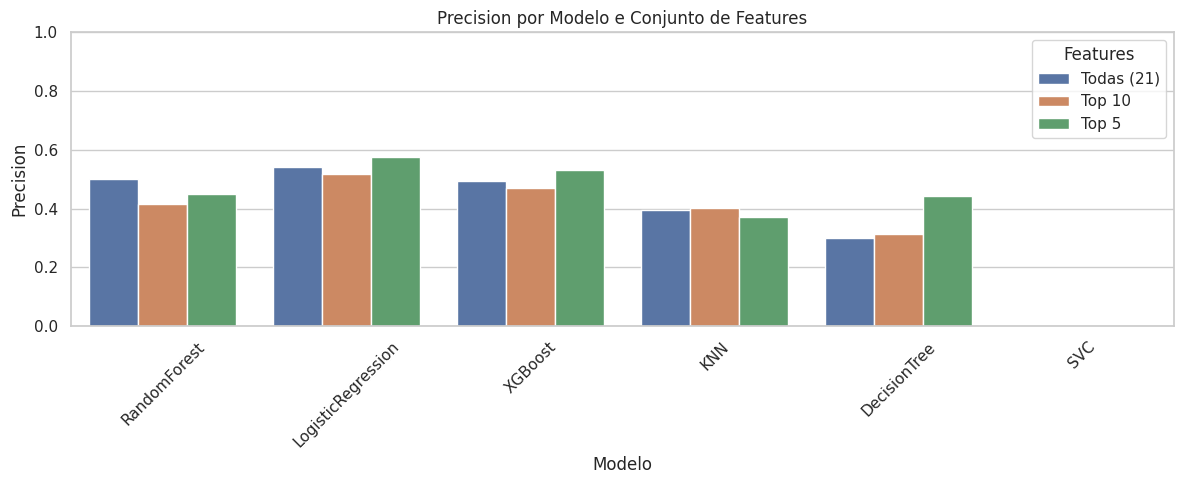

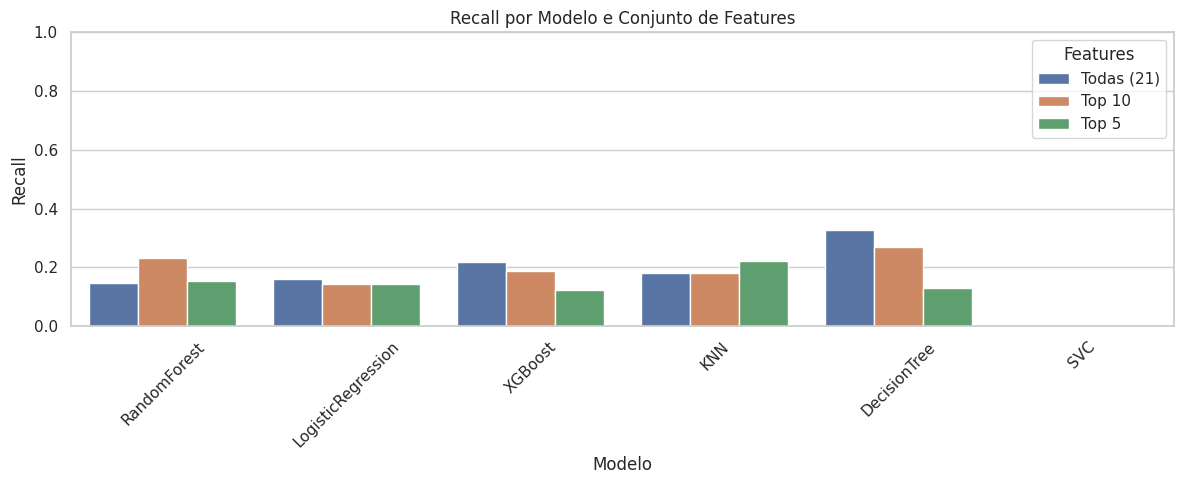

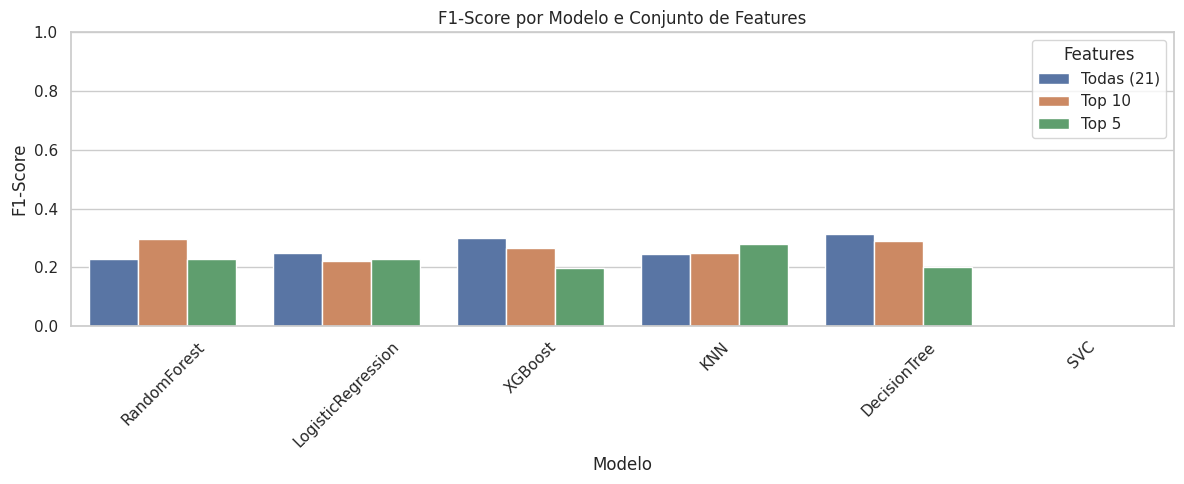

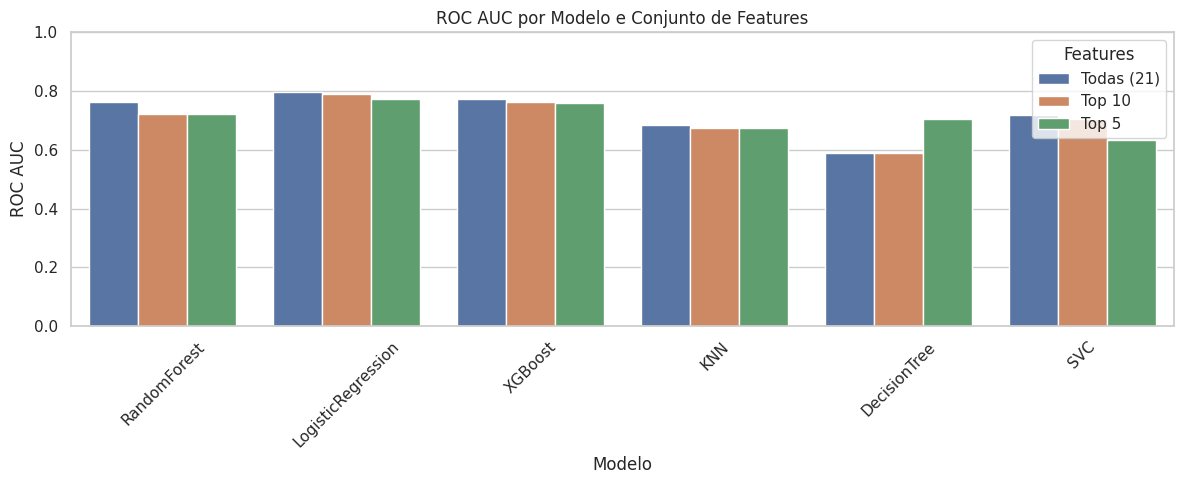

In [ ]:
# Subconjunto reduzido para teste
df_clean_sample = df_clean.sample(frac=0.1, random_state=42)

# Configurar seaborn
sns.set(style='whitegrid')

# Target
target = 'Diabetes_binary'

# Features
top_10_features = ['GenHlth', 'HighBP', 'BMI', 'DiffWalk', 'HighChol',
                   'Age', 'HeartDiseaseorAttack', 'PhysHlth', 'Stroke', 'MentHlth']
top_5_features = top_10_features[:5]

# Conjuntos de features
feature_sets = {
    'Todas (21)': df_clean_sample.drop(columns=[target]).columns.tolist(),
    'Top 10': top_10_features,
    'Top 5': top_5_features
}

# Modelos
models = {
    'RandomForest': RandomForestClassifier(n_estimators=50, random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'KNN': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'SVC': SVC(probability=True)
}

# Lista para armazenar resultados
all_results = []

# Loop pelos conjuntos de features e modelos
for feat_name, feat_cols in feature_sets.items():
    X = df_clean_sample[feat_cols]
    y = df_clean_sample[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        all_results.append({
            'Modelo': model_name,
            'Features': feat_name,
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1-Score': f1_score(y_test, y_pred),
            'ROC AUC': roc_auc_score(y_test, y_proba)
        })

# Converter resultados em DataFrame
results_df = pd.DataFrame(all_results)

# Plotar métricas
metrics = ['Precision', 'Recall', 'F1-Score', 'ROC AUC']

for metric in metrics:
    plt.figure(figsize=(12, 5))
    sns.barplot(data=results_df, x='Modelo', y=metric, hue='Features')
    plt.title(f'{metric} por Modelo e Conjunto de Features')
    plt.ylim(0, 1)
    plt.legend(title='Features')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


🏆 Melhores modelos por conjunto de features (AUC-ROC):
     Features              Modelo   AUC-ROC  Precision    Recall  F1-Score
0  Todas (21)  LogisticRegression  0.797557   0.542522  0.160312  0.247492
1      Top 10  LogisticRegression  0.790472   0.519108  0.141248  0.222071
2       Top 5  LogisticRegression  0.774652   0.573944  0.141248  0.226704


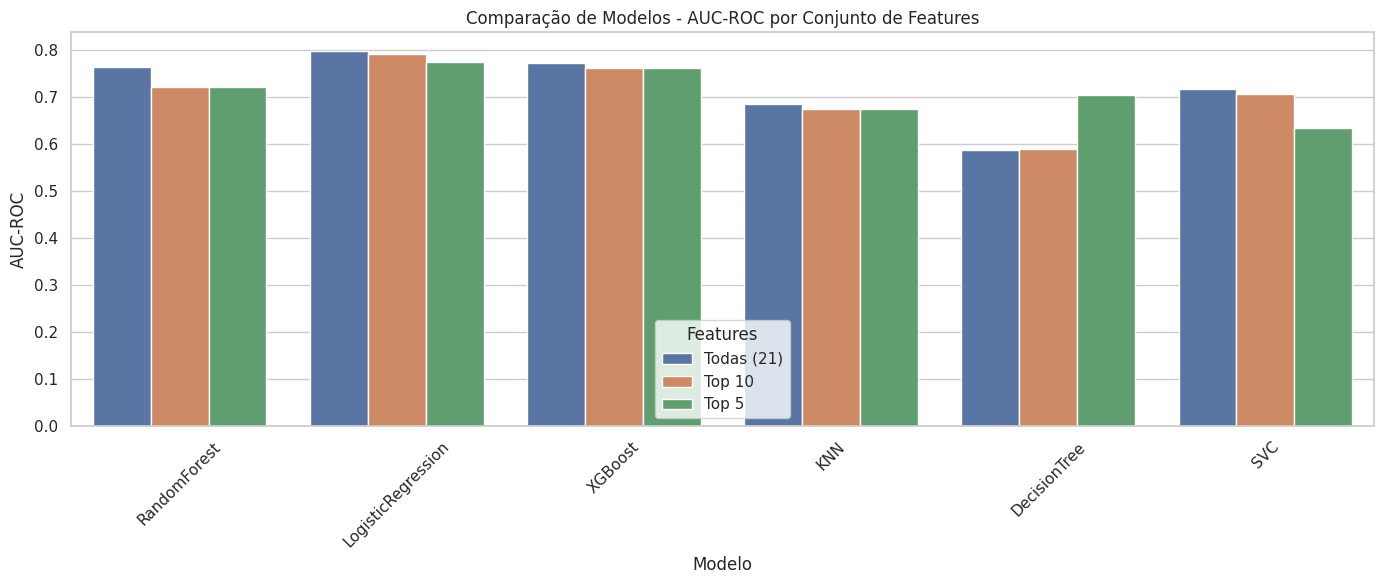

In [ ]:
# Sample 10% para acelerar testes
df_clean_sample = df_clean.sample(frac=0.1, random_state=42)

# Configurar seaborn
sns.set(style='whitegrid')

# Target e Features
target = 'Diabetes_binary'
top_10_features = ['GenHlth', 'HighBP', 'BMI', 'DiffWalk', 'HighChol',
                   'Age', 'HeartDiseaseorAttack', 'PhysHlth', 'Stroke', 'MentHlth']
top_5_features = top_10_features[:5]

feature_sets = {
    'Todas (21)': df_clean_sample.drop(columns=[target]).columns.tolist(),
    'Top 10': top_10_features,
    'Top 5': top_5_features
}

models = {
    'RandomForest': RandomForestClassifier(n_estimators=50, random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'KNN': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'SVC': SVC(probability=True)
}

results = []


# Loop para treinar e avaliar todos modelos com todos conjuntos de features
for feat_name, feat_cols in feature_sets.items():
    X = df_clean_sample[feat_cols]
    y = df_clean_sample[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        results.append({
            'Features': feat_name,
            'Modelo': model_name,
            'AUC-ROC': roc_auc_score(y_test, y_prob),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1-Score': f1_score(y_test, y_pred)
        })

# Converter resultados em DataFrame
results_df = pd.DataFrame(results)

# Mostrar melhores modelos por AUC-ROC
melhores = results_df.sort_values(by='AUC-ROC', ascending=False).groupby('Features').first().reset_index()
print("🏆 Melhores modelos por conjunto de features (AUC-ROC):")
print(melhores)

# Plot comparativo
plt.figure(figsize=(14, 6))
sns.barplot(data=results_df, x='Modelo', y='AUC-ROC', hue='Features')
plt.title('Comparação de Modelos - AUC-ROC por Conjunto de Features')
plt.ylabel('AUC-ROC')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


As 10 features selecionadas são:
Index(['GenHlth', 'HighBP', 'HighChol', 'Age', 'Income',
       'HeartDiseaseorAttack', 'DiffWalk', 'PhysHlth', 'BMI', 'MentHlth'],
      dtype='object')
Distribuição das classes ANTES do balanceamento (Treino):
Diabetes_binary
0    155501
1     31726
Name: count, dtype: int64

Distribuição das classes DEPOIS do balanceamento (Treino):
Diabetes_binary
0    155501
1    155501
Name: count, dtype: int64
Modelo: Random Forest, Acurácia: 0.7889
Modelo: KNN, Acurácia: 0.7613
Modelo: Decision Tree, Acurácia: 0.7632
Modelo: Logistic Regression, Acurácia: 0.7082
Modelo: XGBoost, Acurácia: 0.8221

--- Análise Detalhada do Melhor Modelo: XGBoost ---


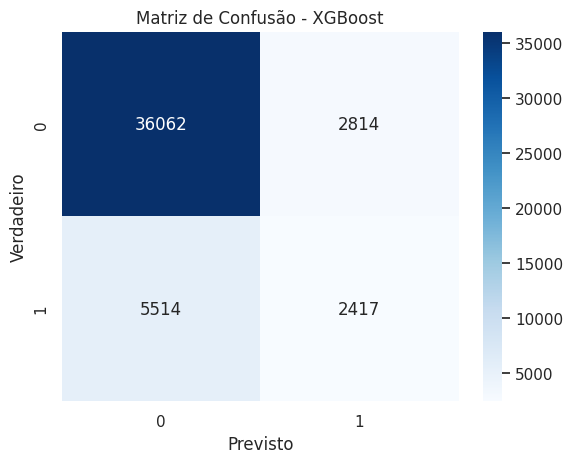


Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     38876
           1       0.46      0.30      0.37      7931

    accuracy                           0.82     46807
   macro avg       0.66      0.62      0.63     46807
weighted avg       0.80      0.82      0.81     46807



In [ ]:
# Célula 5: Seleção de Features (lógica original)
X = df_clean.drop('Diabetes_binary', axis=1)
y = df_clean['Diabetes_binary']

# Selecionando as 10 melhores features
k_best = 10
selector = SelectKBest(score_func=chi2, k=k_best)
X_new = selector.fit_transform(X, y)

# Obtendo os nomes das features selecionadas
selected_features = X.columns[selector.get_support()]
print("As 10 features selecionadas são:")
print(selected_features)

# Criando o DataFrame final com as features selecionadas
X_selected = pd.DataFrame(X_new, columns=selected_features)


# Célula 6: <<< MODELAGEM E TREINAMENTO COM BALANCEAMENTO >>>

# 1. Divisão em Treino e Teste (como antes)
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

print("Distribuição das classes ANTES do balanceamento (Treino):")
print(y_train.value_counts())

# 2. Aplicação do SMOTE (APENAS nos dados de treino)
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("\nDistribuição das classes DEPOIS do balanceamento (Treino):")
print(y_train_balanced.value_counts())

# 3. Escalonamento dos Dados (StandardScaler)
# O scaler é treinado nos dados de treino (balanceados ou não, a prática varia, mas treinar no original é comum)
# e aplicado em ambos os conjuntos. Vamos treinar no original para não vazar informação sintética.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced) # Treina e transforma os dados de treino balanceados
X_test_scaled = scaler.transform(X_test) # Apenas transforma os dados de teste


# 4. Treinamento dos Modelos (usando os dados balanceados)
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

results = {}
for name, model in models.items():
    # Treinando com X_train_balanced e y_train_balanced
    model.fit(X_train_scaled, y_train_balanced)
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    results[0] = accuracy
    print(f"Modelo: {name}, Acurácia: {accuracy:.4f}")

# Célula 7: Avaliação detalhada do melhor modelo (ex: XGBoost)
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
print(f"\n--- Análise Detalhada do Melhor Modelo: {best_model_name} ---")

# Previsões são feitas no conjunto de teste original e não balanceado
y_pred_best = best_model.predict(X_test_scaled)

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.title(f'Matriz de Confusão - {best_model_name}')
plt.show()

# Relatório de Classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_best))

🚀 Iniciando a Otimização de Hiperparâmetros para o XGBoost...
Valor calculado para 'scale_pos_weight': 4.90
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Melhores parâmetros encontrados:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'scale_pos_weight': np.float64(4.90137426716258)}

🚀 Iniciando o Ajuste do Limiar de Decisão...

Melhor F1-Score encontrado: 0.4693
Limiar ótimo que maximiza o F1-Score: 0.7585


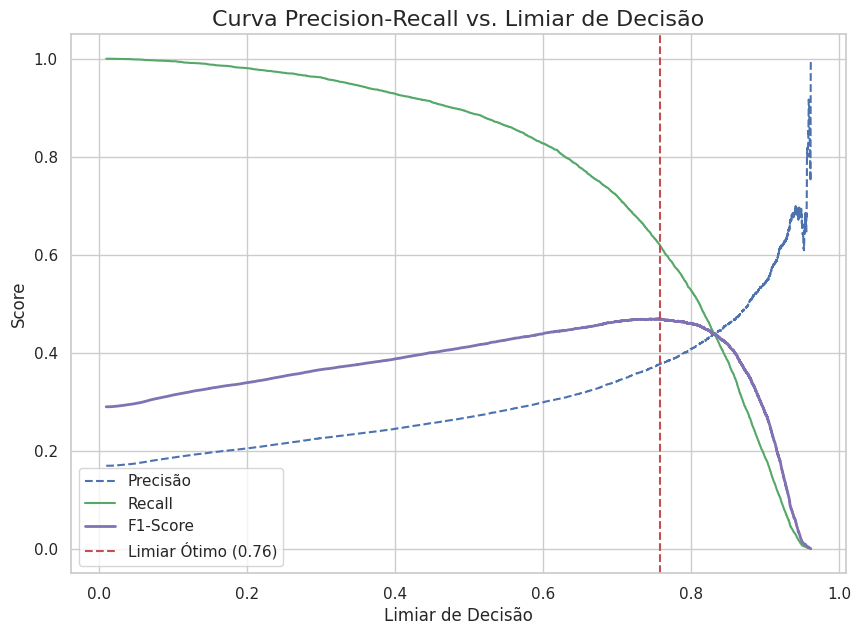


📊 Relatório de Classificação Final com o Modelo Otimizado e Limiar Ajustado:
              precision    recall  f1-score   support

           0       0.91      0.79      0.85     38876
           1       0.38      0.62      0.47      7931

    accuracy                           0.76     46807
   macro avg       0.64      0.71      0.66     46807
weighted avg       0.82      0.76      0.78     46807


📊 Matriz de Confusão do Modelo Final:


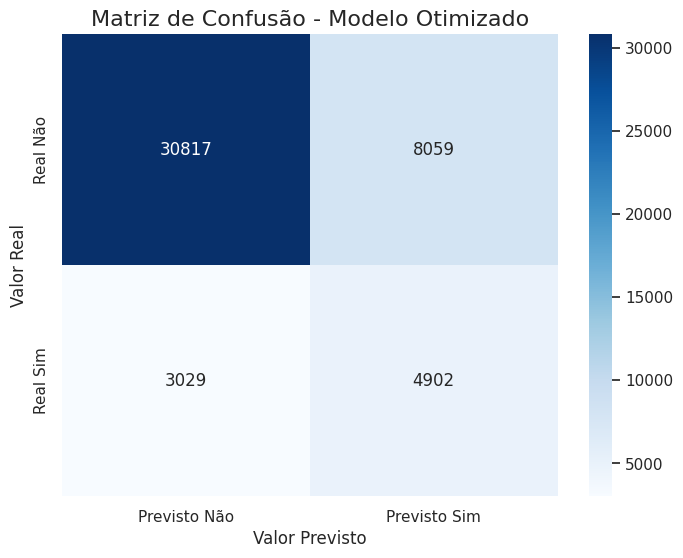

In [ ]:
# ==============================================================================
# OTIMIZAÇÃO DE HIPERPARÂMETROS COM GRIDSEARCHCV
# ==============================================================================
print("🚀 Iniciando a Otimização de Hiperparâmetros para o XGBoost...")

# 1.1. Calcular o 'scale_pos_weight'.
counts = y_train.value_counts()
scale_pos_weight_value = counts[0] / counts[1]
print(f"Valor calculado para 'scale_pos_weight': {scale_pos_weight_value:.2f}")

# 1.2. Definir o espaço de parâmetros para testar.
param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.2],
    'n_estimators': [100, 200],
    'scale_pos_weight': [scale_pos_weight_value]
}

# 1.3. Configurar e rodar o GridSearchCV.
grid_search = GridSearchCV(
    estimator=XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Treinando o grid_search com os dados balanceados por SMOTE
grid_search.fit(X_train_scaled, y_train_balanced)

# 1.4. Obter o melhor modelo e seus parâmetros.
best_xgb = grid_search.best_estimator_
print("\nMelhores parâmetros encontrados:")
print(grid_search.best_params_)

# ==============================================================================
# Tentativa 2: AJUSTE DO LIMIAR DE DECISÃO (THRESHOLD TUNING)
# ==============================================================================
print("\n🚀 Iniciando o Ajuste do Limiar de Decisão...")

# 2.1. Obter as probabilidades previstas pelo MELHOR modelo no conjunto de teste.
y_probs = best_xgb.predict_proba(X_test_scaled)[:, 1]

# 2.2. Calcular precisão, recall e limiares.
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# 2.3. Encontrar o limiar que maximiza o F1-Score.
f1_scores = (2 * precision * recall) / (precision + recall + 1e-9)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"\nMelhor F1-Score encontrado: {f1_scores[optimal_idx]:.4f}")
print(f"Limiar ótimo que maximiza o F1-Score: {optimal_threshold:.4f}")

# 2.4. Visualizar a curva Precision-Recall.
plt.figure(figsize=(10, 7))
plt.plot(thresholds, precision[:-1], 'b--', label='Precisão')
plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
plt.plot(thresholds, f1_scores[:-1], 'm-', label='F1-Score', linewidth=2)
plt.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Limiar Ótimo ({optimal_threshold:.2f})')
plt.title('Curva Precision-Recall vs. Limiar de Decisão', fontsize=16)
plt.xlabel('Limiar de Decisão')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

# 2.5. Avaliar o modelo final usando o limiar ótimo.
y_pred_optimal = (y_probs >= optimal_threshold).astype(int)

print("\n📊 Relatório de Classificação Final com o Modelo Otimizado e Limiar Ajustado:")
print(classification_report(y_test, y_pred_optimal))

# ==============================================================================
#                      NOVA CÉLULA: MATRIZ DE CONFUSÃO FINAL
# ==============================================================================
# 2.6. Visualizar a Matriz de Confusão para o modelo otimizado
print("\n📊 Matriz de Confusão do Modelo Final:")

# Calcular a matriz
cm_optimal = confusion_matrix(y_test, y_pred_optimal)

# Criar o gráfico
plt.figure(figsize=(8, 6))
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Previsto Não', 'Previsto Sim'],
            yticklabels=['Real Não', 'Real Sim'])
plt.title('Matriz de Confusão - Modelo Otimizado', fontsize=16)
plt.ylabel('Valor Real', fontsize=12)
plt.xlabel('Valor Previsto', fontsize=12)
plt.show()